In [12]:
import numpy as np
import mxnet as mx
from mxnet import gluon, autograd ,nd
from mxnet.gluon import nn, utils
import mxnet.ndarray as F
import cv2

In [13]:
mx.__version__

'1.1.0'

### Data loader 생성
- gluon의 DataLoader를 활용함
- 이미지 데이터의 경우에는 0 ~255  의 값을 가짐 -> 위 문제의 경우에는 127.5로 나눈 후 -1 을 하는 방법으로 normalization 수행
- 기본적으로 image data형태는 NHWC(Number, Height, Width, Channel)의 형태이나 gluon의 데이터 입력 방식은 기본적으로 NCHW임 -> reshape를 수행하여서 데이터 형태를 맞춤

In [14]:
##load fashion-MNIST
def transform(data, label):
    return mx.nd.transpose(data.astype(np.float32), (2,0,1))/127.5 - 1, label.astype(np.float32)

train_data = gluon.data.DataLoader(
    #gluon.data.vision.FashionMNIST(train=True, transform=transform), batch_size=32, shuffle=True,last_batch='discard')
    gluon.data.vision.FashionMNIST(train=True, transform=transform), batch_size=32, shuffle=True,last_batch='discard')

validation_data = gluon.data.DataLoader(
    #gluon.data.vision.FashionMNIST(train=False, transform=transform), batch_size=32, shuffle=False,last_batch='discard')
    gluon.data.vision.FashionMNIST(train=False, transform=transform), batch_size=32, shuffle=False,last_batch='discard')

/opt/venv/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:118: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  label = np.fromstring(fin.read(), dtype=np.uint8).astype(np.int32)
/opt/venv/lib/python3.6/site-packages/mxnet/gluon/data/vision/datasets.py:122: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(fin.read(), dtype=np.uint8)


In [15]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#imgplot = plt.imshow(X[0][0] * 255,cmap='gray')
#plt.show()

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


Populating the interactive namespace from numpy and matplotlib


/opt/venv/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### 학습을 위한 hyperparameter을 설정함
- epoches : 총 Epoch 크기
- batch size : 네트워크에 투입되는 Data 크기
- latent_z_size : random data 크기
- use_gpu : gpu 사용 여부
- ctx : Context의 의미로 gluon 에서는 데이터 처리를 cpu 에서 할지 gpu에서 할지를 ctx를 통해 지정해줌(default : cpu)
- lr : learning rate

In [16]:
epochs = 20 
batch_size = 32
latent_z_size = 100

use_gpu = True
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5

#### Generator 설정
- 기본적으로 Generator와 Discriminator가 동일한 형태로 되어 있음 (정방향/역방향)
- Generator의 경우에는 Conv2DTranspose를 활용함
- 데이터 크기의 변화 과정 (Channel X Height X Width)
   - Input Data : 100 X 1 X 1
   - 1st Conv2DTr. : (32*8) X 4 X 4
   - 2nd Conv2DTr. :  (32*4) X 8 X 8
   - 3rd Conv2DTr. :  (32*2) X 16 X 16
   - 4th Conv2DTr. :  (32*1) X 32 X 32
   - 5th Conv2DTr. :  1 X 32 X 32

In [17]:
# build the generator
nc = 1
ngf = 32
netG = nn.Sequential()
with netG.name_scope():
    # input is Z, going into a convolution
    netG.add(nn.Conv2DTranspose(ngf * 8, 4, 1, 0, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*8) x 4 x 4
    netG.add(nn.Conv2DTranspose(ngf * 4, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*4) x 8 x 8
    netG.add(nn.Conv2DTranspose(ngf * 2, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. (ngf*2) x 16 x 16
    netG.add(nn.Conv2DTranspose(ngf, 4, 2, 1, use_bias=False))
    netG.add(nn.BatchNorm())
    netG.add(nn.Activation('relu'))
    # state size. () x 32 x 32
    netG.add(nn.Conv2DTranspose(nc, 3, 1, 1, use_bias=False))
    netG.add(nn.Activation('tanh'))
    # state size. (nc) x 64 x 64

#### Discriminator 설정
- Discriminator 경우에는 Conv2D를 활용함
- 데이터 크기의 변화 과정 (Channel X Height X Width)
   - Input Data    : 1 X 32 X 32
   - 1st Conv2DTr. :  (64*1) X 32 X 32 
   - 2nd Conv2DTr. :  (64*2) X 16 X 16 
   - 3rd Conv2DTr. :  (64*4) X 8 X 8
   - 4th Conv2DTr. :  (64*8) X 4 X 4
   - 5th Conv2DTr. :  64 X 1 X 1

In [18]:
# build the discriminator
ndf = 32
netD = nn.Sequential()
with netD.name_scope():
    # input is (nc) x 64 x 64
    netD.add(nn.Conv2D(ndf, 3, 1, 1, use_bias=False))
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf) x 32 x 32
    netD.add(nn.Conv2D(ndf * 2, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*2) x 16 x 16
    netD.add(nn.Conv2D(ndf * 4, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*4) x 8 x 8
    netD.add(nn.Conv2D(ndf * 8, 4, 2, 1, use_bias=False))
    netD.add(nn.BatchNorm())
    netD.add(nn.LeakyReLU(0.2))
    # state size. (ndf*8) x 4 x 4
    netD.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))
    # state size. (ndf) x 1 x 1

### loss 및 optimizer 정의
- 해당 문제에서는 sigmoid Binary CrossEntropy를 적용
- gluon에서 네트워크를 활용하기 위해서는 parameter에 대한 초기화 작업이 필요
- optimizer의 경우에는 Adam을 적용

In [19]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()
# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [20]:
netG

Sequential(
  (0): Conv2DTranspose(256 -> 0, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (2): Activation(relu)
  (3): Conv2DTranspose(128 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (5): Activation(relu)
  (6): Conv2DTranspose(64 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (8): Activation(relu)
  (9): Conv2DTranspose(32 -> 0, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (11): Activation(relu)
  (12): Conv2DTranspose(1 -> 0, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [21]:
netD

Sequential(
  (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): LeakyReLU(0.2)
  (2): Conv2D(None -> 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (3): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (4): LeakyReLU(0.2)
  (5): Conv2D(None -> 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (6): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (7): LeakyReLU(0.2)
  (8): Conv2D(None -> 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (9): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
  (10): LeakyReLU(0.2)
  (11): Conv2D(None -> 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
)

INFO:root:speed: 173.986072582276 samples/s
INFO:root:discriminator loss = 1.362433, generator loss = 2.196691, binary training acc = 0.609375 at iter 0 epoch 0


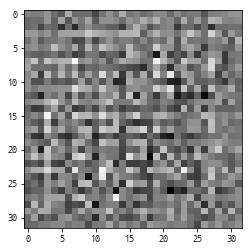

INFO:root:speed: 558.7655825881334 samples/s
INFO:root:discriminator loss = 0.425147, generator loss = 2.400226, binary training acc = 0.905941 at iter 100 epoch 0


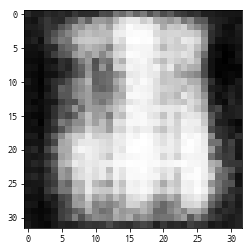

INFO:root:speed: 1375.6185673728337 samples/s
INFO:root:discriminator loss = 0.331678, generator loss = 4.185916, binary training acc = 0.919232 at iter 200 epoch 0


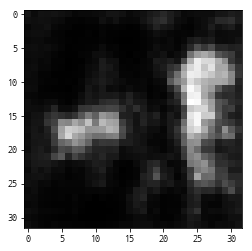

INFO:root:speed: 1097.877564375225 samples/s
INFO:root:discriminator loss = 0.359558, generator loss = 2.580162, binary training acc = 0.930804 at iter 300 epoch 0


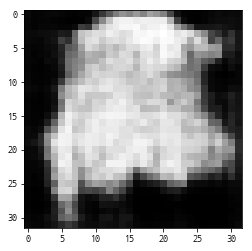

INFO:root:speed: 805.2999256005952 samples/s
INFO:root:discriminator loss = 0.174207, generator loss = 3.698424, binary training acc = 0.925538 at iter 400 epoch 0


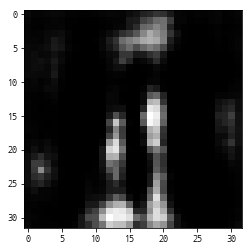

INFO:root:speed: 1237.9539379629032 samples/s
INFO:root:discriminator loss = 0.237737, generator loss = 3.257443, binary training acc = 0.926927 at iter 500 epoch 0


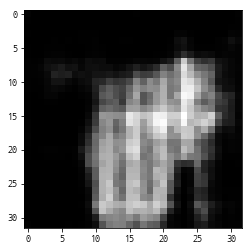

INFO:root:speed: 754.8718687078886 samples/s
INFO:root:discriminator loss = 0.658649, generator loss = 2.860600, binary training acc = 0.919509 at iter 600 epoch 0


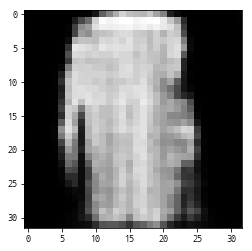

INFO:root:speed: 908.0852756709945 samples/s
INFO:root:discriminator loss = 0.409064, generator loss = 3.818793, binary training acc = 0.914765 at iter 700 epoch 0


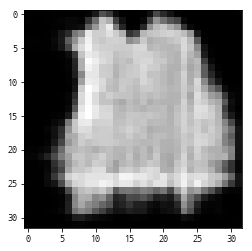

INFO:root:speed: 1400.1870285946775 samples/s
INFO:root:discriminator loss = 0.570689, generator loss = 2.230493, binary training acc = 0.912648 at iter 800 epoch 0


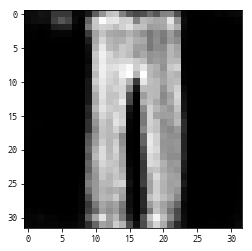

INFO:root:speed: 166.57014816828064 samples/s
INFO:root:discriminator loss = 0.698884, generator loss = 2.606829, binary training acc = 0.908175 at iter 900 epoch 0


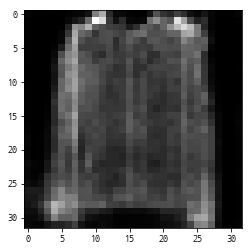

INFO:root:speed: 1311.962777240159 samples/s
INFO:root:discriminator loss = 0.560443, generator loss = 2.934711, binary training acc = 0.906110 at iter 1000 epoch 0


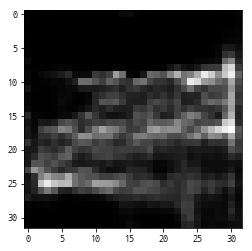

INFO:root:speed: 888.2120839123817 samples/s
INFO:root:discriminator loss = 0.714561, generator loss = 3.325598, binary training acc = 0.902603 at iter 1100 epoch 0


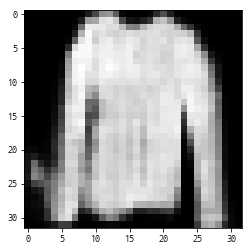

INFO:root:speed: 865.8091085021288 samples/s
INFO:root:discriminator loss = 0.629365, generator loss = 3.059196, binary training acc = 0.900409 at iter 1200 epoch 0


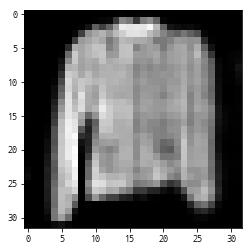

INFO:root:speed: 1134.2087614926988 samples/s
INFO:root:discriminator loss = 0.432565, generator loss = 2.743194, binary training acc = 0.898047 at iter 1300 epoch 0


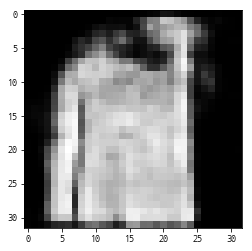

INFO:root:speed: 146.9373606222665 samples/s
INFO:root:discriminator loss = 0.423353, generator loss = 3.345128, binary training acc = 0.897874 at iter 1400 epoch 0


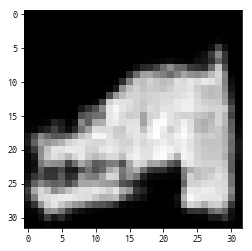

INFO:root:speed: 1051.434587785542 samples/s
INFO:root:discriminator loss = 0.476275, generator loss = 3.783514, binary training acc = 0.894789 at iter 1500 epoch 0


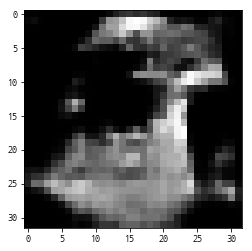

INFO:root:speed: 836.0183376519833 samples/s
INFO:root:discriminator loss = 0.672967, generator loss = 3.842961, binary training acc = 0.894070 at iter 1600 epoch 0


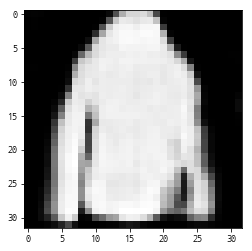

INFO:root:speed: 1137.2167119968142 samples/s
INFO:root:discriminator loss = 0.717538, generator loss = 2.780395, binary training acc = 0.893454 at iter 1700 epoch 0


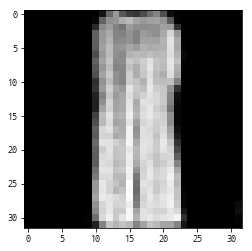

INFO:root:speed: 1164.5385669911673 samples/s
INFO:root:discriminator loss = 0.368879, generator loss = 3.615103, binary training acc = 0.893497 at iter 1800 epoch 0


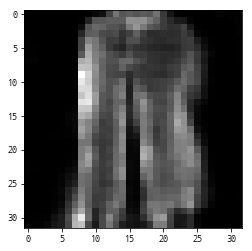

INFO:root:speed: 437.2967034399171 samples/s
INFO:root:discriminator loss = 0.692150, generator loss = 2.029239, binary training acc = 0.859375 at iter 0 epoch 1


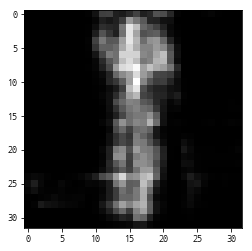

INFO:root:speed: 1385.0444043135028 samples/s
INFO:root:discriminator loss = 0.384584, generator loss = 3.250024, binary training acc = 0.897432 at iter 100 epoch 1


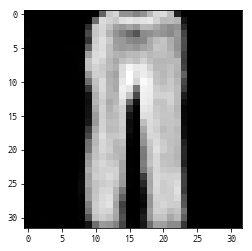

INFO:root:speed: 995.2522505153569 samples/s
INFO:root:discriminator loss = 0.259474, generator loss = 3.007965, binary training acc = 0.897077 at iter 200 epoch 1


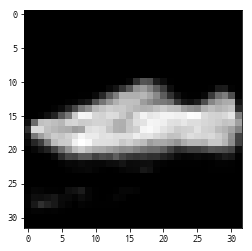

INFO:root:speed: 550.788228969604 samples/s
INFO:root:discriminator loss = 0.321894, generator loss = 4.351910, binary training acc = 0.904225 at iter 300 epoch 1


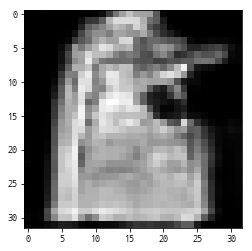

INFO:root:speed: 1164.841769075887 samples/s
INFO:root:discriminator loss = 0.192008, generator loss = 3.839270, binary training acc = 0.912913 at iter 400 epoch 1


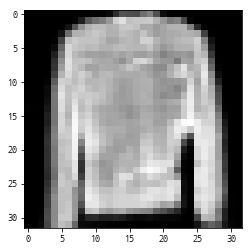

INFO:root:speed: 1290.5054420983809 samples/s
INFO:root:discriminator loss = 0.189416, generator loss = 3.839859, binary training acc = 0.923840 at iter 500 epoch 1


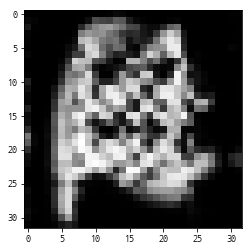

INFO:root:speed: 1109.7785531788227 samples/s
INFO:root:discriminator loss = 0.160015, generator loss = 3.648667, binary training acc = 0.931910 at iter 600 epoch 1


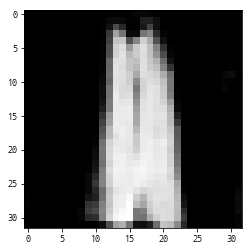

INFO:root:speed: 1250.141837894227 samples/s
INFO:root:discriminator loss = 0.108022, generator loss = 4.273884, binary training acc = 0.938369 at iter 700 epoch 1


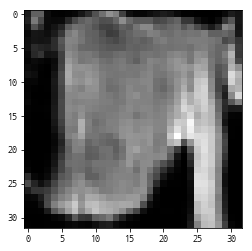

INFO:root:speed: 1166.5324838992847 samples/s
INFO:root:discriminator loss = 1.047003, generator loss = 2.812438, binary training acc = 0.941694 at iter 800 epoch 1


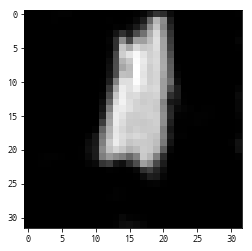

INFO:root:speed: 327.2078812065599 samples/s
INFO:root:discriminator loss = 0.144176, generator loss = 4.331120, binary training acc = 0.939026 at iter 900 epoch 1


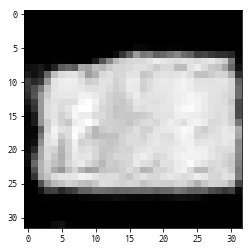

INFO:root:speed: 1095.163216515034 samples/s
INFO:root:discriminator loss = 0.098732, generator loss = 4.062037, binary training acc = 0.941683 at iter 1000 epoch 1


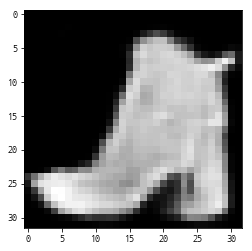

INFO:root:speed: 775.0096892286728 samples/s
INFO:root:discriminator loss = 0.094507, generator loss = 3.948179, binary training acc = 0.946583 at iter 1100 epoch 1


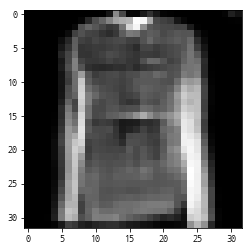

INFO:root:speed: 546.7050423009088 samples/s
INFO:root:discriminator loss = 0.108385, generator loss = 3.937176, binary training acc = 0.950835 at iter 1200 epoch 1


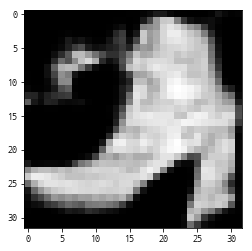

INFO:root:speed: 577.4817377236801 samples/s
INFO:root:discriminator loss = 1.216253, generator loss = 1.908155, binary training acc = 0.949894 at iter 1300 epoch 1


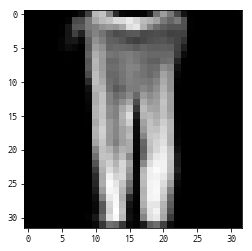

INFO:root:speed: 1071.7783261065726 samples/s
INFO:root:discriminator loss = 1.278095, generator loss = 1.546065, binary training acc = 0.941180 at iter 1400 epoch 1


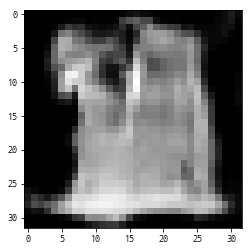

INFO:root:speed: 1202.8402638371092 samples/s
INFO:root:discriminator loss = 0.142618, generator loss = 3.942043, binary training acc = 0.943288 at iter 1500 epoch 1


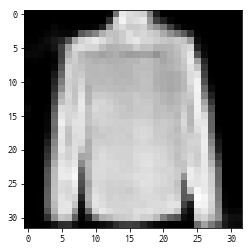

INFO:root:speed: 482.4400911554747 samples/s
INFO:root:discriminator loss = 0.116528, generator loss = 4.940779, binary training acc = 0.943375 at iter 1600 epoch 1


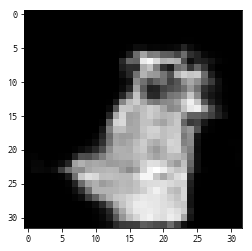

INFO:root:speed: 1066.7609404059833 samples/s
INFO:root:discriminator loss = 0.035297, generator loss = 5.095762, binary training acc = 0.946465 at iter 1700 epoch 1


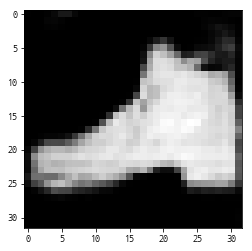

INFO:root:speed: 1192.9616382835 samples/s
INFO:root:discriminator loss = 0.552953, generator loss = 4.447169, binary training acc = 0.948258 at iter 1800 epoch 1


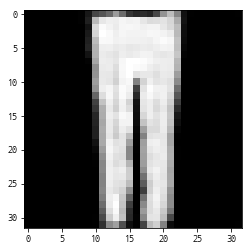

INFO:root:speed: 383.52414997185383 samples/s
INFO:root:discriminator loss = 0.045926, generator loss = 4.921609, binary training acc = 1.000000 at iter 0 epoch 2


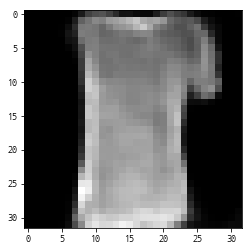

INFO:root:speed: 874.9582982939914 samples/s
INFO:root:discriminator loss = 0.049737, generator loss = 4.930022, binary training acc = 0.943998 at iter 100 epoch 2


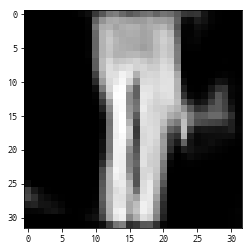

INFO:root:speed: 1215.002923950139 samples/s
INFO:root:discriminator loss = 0.040266, generator loss = 5.250486, binary training acc = 0.971004 at iter 200 epoch 2


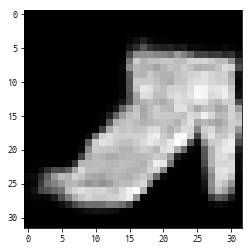

INFO:root:speed: 149.24921326474558 samples/s
INFO:root:discriminator loss = 0.046848, generator loss = 4.702559, binary training acc = 0.980118 at iter 300 epoch 2


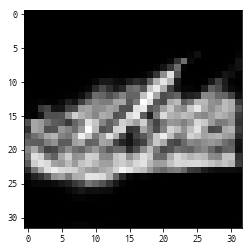

INFO:root:speed: 906.8336497598086 samples/s
INFO:root:discriminator loss = 0.036422, generator loss = 4.771904, binary training acc = 0.984882 at iter 400 epoch 2


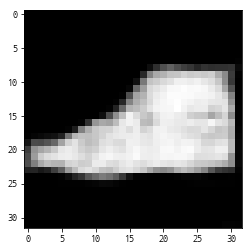

INFO:root:speed: 1084.3598759048605 samples/s
INFO:root:discriminator loss = 0.010395, generator loss = 5.588484, binary training acc = 0.987712 at iter 500 epoch 2


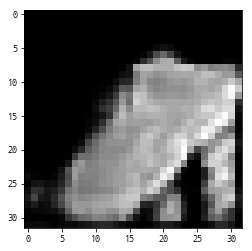

INFO:root:speed: 1094.4666443779406 samples/s
INFO:root:discriminator loss = 0.034274, generator loss = 4.994668, binary training acc = 0.989627 at iter 600 epoch 2


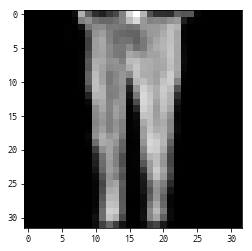

INFO:root:speed: 1212.0952208936892 samples/s
INFO:root:discriminator loss = 0.014335, generator loss = 6.590475, binary training acc = 0.991106 at iter 700 epoch 2


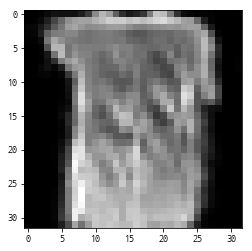

INFO:root:speed: 759.768861516167 samples/s
INFO:root:discriminator loss = 0.039011, generator loss = 4.937072, binary training acc = 0.992217 at iter 800 epoch 2


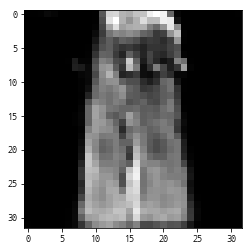

INFO:root:speed: 103.02330229737717 samples/s
INFO:root:discriminator loss = 0.011931, generator loss = 5.644051, binary training acc = 0.993063 at iter 900 epoch 2


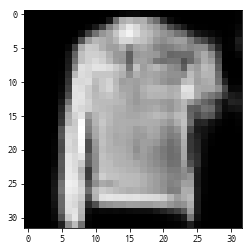

INFO:root:speed: 1310.822408000625 samples/s
INFO:root:discriminator loss = 0.556215, generator loss = 4.709653, binary training acc = 0.982705 at iter 1000 epoch 2


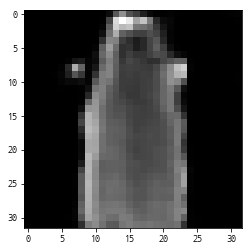

INFO:root:speed: 585.6075115404417 samples/s
INFO:root:discriminator loss = 1.057402, generator loss = 4.253349, binary training acc = 0.975264 at iter 1100 epoch 2


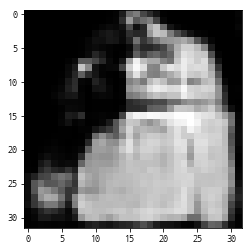

INFO:root:speed: 1073.6988760449583 samples/s
INFO:root:discriminator loss = 0.665480, generator loss = 1.928337, binary training acc = 0.969427 at iter 1200 epoch 2


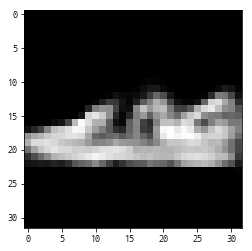

INFO:root:speed: 1068.467866610411 samples/s
INFO:root:discriminator loss = 0.200480, generator loss = 4.204020, binary training acc = 0.968882 at iter 1300 epoch 2


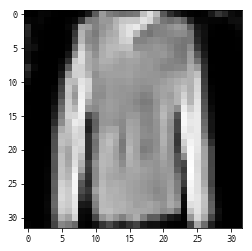

INFO:root:speed: 1277.4611006415016 samples/s
INFO:root:discriminator loss = 0.008982, generator loss = 5.504641, binary training acc = 0.970880 at iter 1400 epoch 2


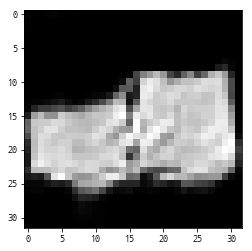

INFO:root:speed: 1117.7824526337706 samples/s
INFO:root:discriminator loss = 0.032975, generator loss = 5.184646, binary training acc = 0.972737 at iter 1500 epoch 2


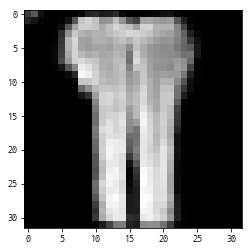

INFO:root:speed: 1320.2219883340056 samples/s
INFO:root:discriminator loss = 0.022875, generator loss = 5.715438, binary training acc = 0.973844 at iter 1600 epoch 2


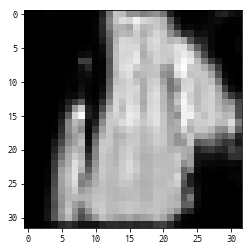

INFO:root:speed: 1086.5544743616729 samples/s
INFO:root:discriminator loss = 0.178145, generator loss = 2.960959, binary training acc = 0.975309 at iter 1700 epoch 2


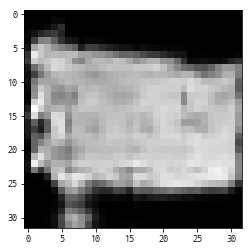

INFO:root:speed: 466.72089465045764 samples/s
INFO:root:discriminator loss = 0.019371, generator loss = 5.276742, binary training acc = 0.976541 at iter 1800 epoch 2


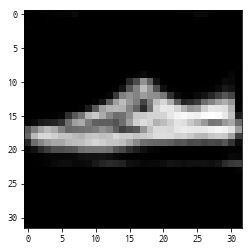

INFO:root:speed: 311.38258807808126 samples/s
INFO:root:discriminator loss = 0.016988, generator loss = 7.436430, binary training acc = 1.000000 at iter 0 epoch 3


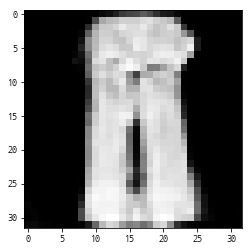

INFO:root:speed: 1234.7196305529746 samples/s
INFO:root:discriminator loss = 0.032200, generator loss = 4.898996, binary training acc = 1.000000 at iter 100 epoch 3


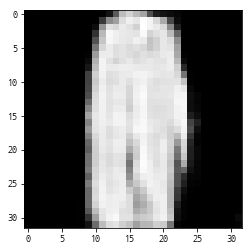

INFO:root:speed: 891.3975426711828 samples/s
INFO:root:discriminator loss = 0.369345, generator loss = 3.733828, binary training acc = 0.938355 at iter 200 epoch 3


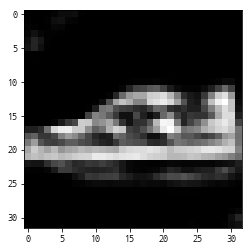

INFO:root:speed: 623.5927018626326 samples/s
INFO:root:discriminator loss = 0.294124, generator loss = 3.569390, binary training acc = 0.928260 at iter 300 epoch 3


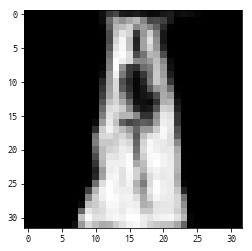

INFO:root:speed: 1098.0751697619241 samples/s
INFO:root:discriminator loss = 0.469181, generator loss = 4.304952, binary training acc = 0.928304 at iter 400 epoch 3


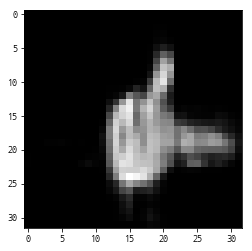

INFO:root:speed: 1222.9071460461219 samples/s
INFO:root:discriminator loss = 0.042739, generator loss = 4.852905, binary training acc = 0.939028 at iter 500 epoch 3


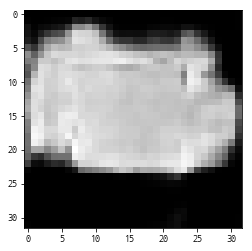

INFO:root:speed: 737.8330144908415 samples/s
INFO:root:discriminator loss = 0.049435, generator loss = 5.062952, binary training acc = 0.949017 at iter 600 epoch 3


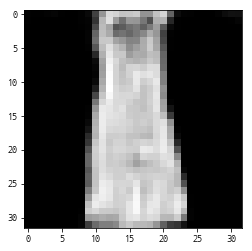

INFO:root:speed: 936.8428517582678 samples/s
INFO:root:discriminator loss = 0.469395, generator loss = 3.372319, binary training acc = 0.954908 at iter 700 epoch 3


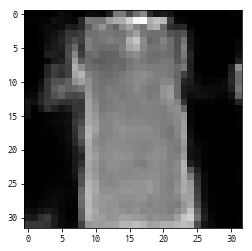

INFO:root:speed: 1194.0866532623975 samples/s
INFO:root:discriminator loss = 0.028851, generator loss = 4.870029, binary training acc = 0.956461 at iter 800 epoch 3


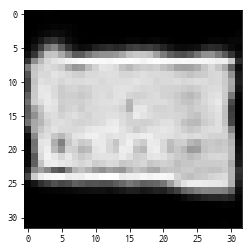

INFO:root:speed: 1081.4329753204793 samples/s
INFO:root:discriminator loss = 0.022795, generator loss = 5.690022, binary training acc = 0.961033 at iter 900 epoch 3


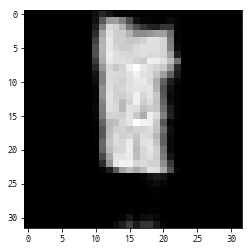

INFO:root:speed: 872.1779995841131 samples/s
INFO:root:discriminator loss = 0.035961, generator loss = 7.010571, binary training acc = 0.964801 at iter 1000 epoch 3


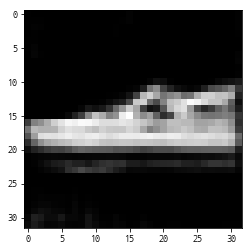

INFO:root:speed: 1128.0127746121393 samples/s
INFO:root:discriminator loss = 0.014845, generator loss = 5.937736, binary training acc = 0.967998 at iter 1100 epoch 3


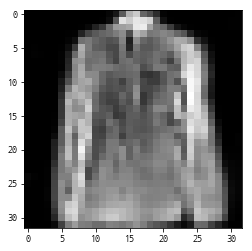

INFO:root:speed: 1083.8519954132144 samples/s
INFO:root:discriminator loss = 0.016763, generator loss = 5.993817, binary training acc = 0.970636 at iter 1200 epoch 3


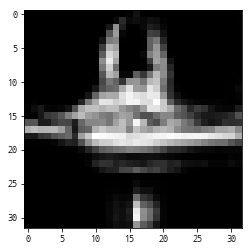

INFO:root:speed: 1287.1021778114482 samples/s
INFO:root:discriminator loss = 0.010008, generator loss = 6.255404, binary training acc = 0.972893 at iter 1300 epoch 3


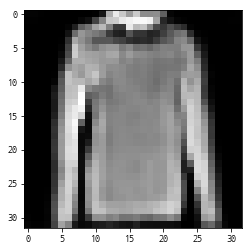

INFO:root:speed: 1115.9330196052347 samples/s
INFO:root:discriminator loss = 0.510639, generator loss = 5.004765, binary training acc = 0.973055 at iter 1400 epoch 3


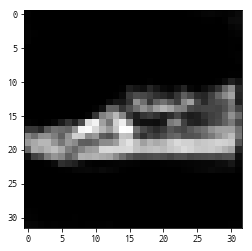

INFO:root:speed: 1274.343951463593 samples/s
INFO:root:discriminator loss = 0.191044, generator loss = 4.106730, binary training acc = 0.966928 at iter 1500 epoch 3


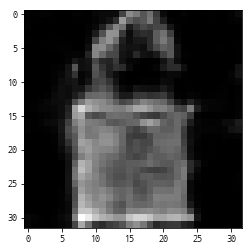

INFO:root:speed: 1018.3748216941334 samples/s
INFO:root:discriminator loss = 0.299606, generator loss = 5.935340, binary training acc = 0.962806 at iter 1600 epoch 3


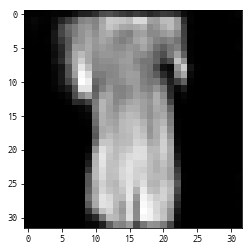

INFO:root:speed: 1142.8621253405995 samples/s
INFO:root:discriminator loss = 0.044875, generator loss = 5.312455, binary training acc = 0.963937 at iter 1700 epoch 3


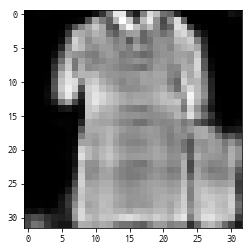

INFO:root:speed: 1165.4182882249256 samples/s
INFO:root:discriminator loss = 0.181590, generator loss = 2.921521, binary training acc = 0.963302 at iter 1800 epoch 3


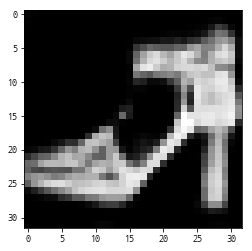

INFO:root:speed: 260.82358062309555 samples/s
INFO:root:discriminator loss = 0.030191, generator loss = 5.416811, binary training acc = 1.000000 at iter 0 epoch 4


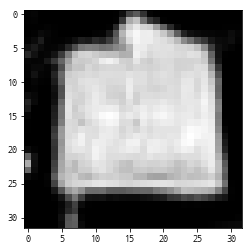

INFO:root:speed: 1430.3131780302224 samples/s
INFO:root:discriminator loss = 3.481854, generator loss = 1.455340, binary training acc = 0.985922 at iter 100 epoch 4


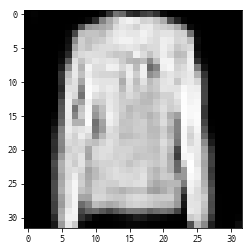

INFO:root:speed: 469.65895785875 samples/s
INFO:root:discriminator loss = 0.772322, generator loss = 4.129648, binary training acc = 0.961598 at iter 200 epoch 4


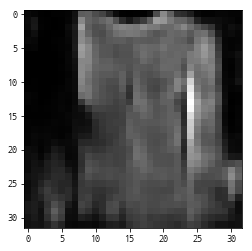

INFO:root:speed: 1258.3226580664516 samples/s
INFO:root:discriminator loss = 0.053978, generator loss = 4.616003, binary training acc = 0.953229 at iter 300 epoch 4


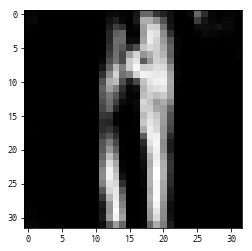

INFO:root:speed: 613.6368865013144 samples/s
INFO:root:discriminator loss = 0.011502, generator loss = 6.248476, binary training acc = 0.964620 at iter 400 epoch 4


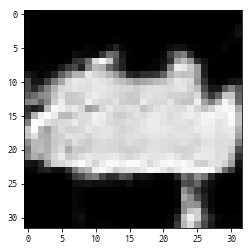

INFO:root:speed: 1265.321643381036 samples/s
INFO:root:discriminator loss = 0.012610, generator loss = 6.799561, binary training acc = 0.971588 at iter 500 epoch 4


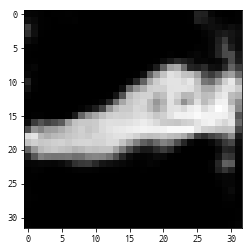

INFO:root:speed: 1058.0071417873387 samples/s
INFO:root:discriminator loss = 0.018350, generator loss = 5.552812, binary training acc = 0.976186 at iter 600 epoch 4


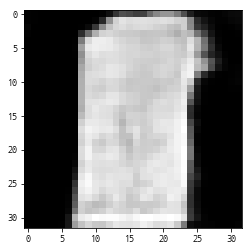

INFO:root:speed: 1052.4899469903705 samples/s
INFO:root:discriminator loss = 0.025637, generator loss = 6.449795, binary training acc = 0.979538 at iter 700 epoch 4


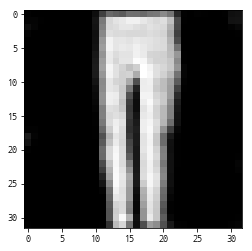

INFO:root:speed: 715.9806252000427 samples/s
INFO:root:discriminator loss = 0.005507, generator loss = 6.593277, binary training acc = 0.982073 at iter 800 epoch 4


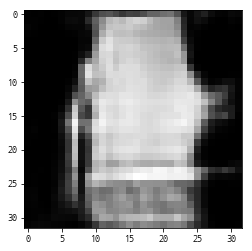

INFO:root:speed: 1025.7059623702753 samples/s
INFO:root:discriminator loss = 0.220488, generator loss = 4.466512, binary training acc = 0.977542 at iter 900 epoch 4


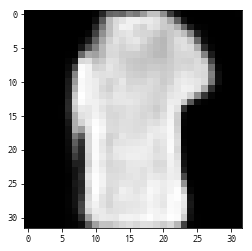

INFO:root:speed: 1263.4753974903274 samples/s
INFO:root:discriminator loss = 0.030287, generator loss = 4.924581, binary training acc = 0.979146 at iter 1000 epoch 4


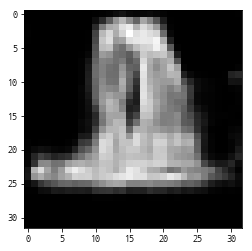

INFO:root:speed: 1105.0000658631363 samples/s
INFO:root:discriminator loss = 0.006850, generator loss = 5.971105, binary training acc = 0.980983 at iter 1100 epoch 4


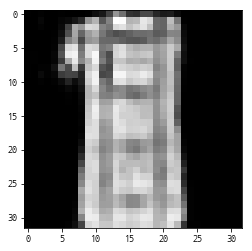

INFO:root:speed: 131.9270781422167 samples/s
INFO:root:discriminator loss = 0.035290, generator loss = 7.637450, binary training acc = 0.982463 at iter 1200 epoch 4


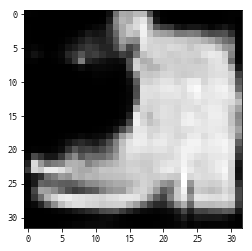

INFO:root:speed: 1156.5409001214982 samples/s
INFO:root:discriminator loss = 0.004521, generator loss = 7.407644, binary training acc = 0.983811 at iter 1300 epoch 4


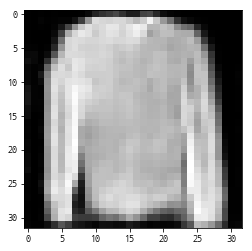

INFO:root:speed: 1320.9106190335597 samples/s
INFO:root:discriminator loss = 0.006367, generator loss = 6.003160, binary training acc = 0.984955 at iter 1400 epoch 4


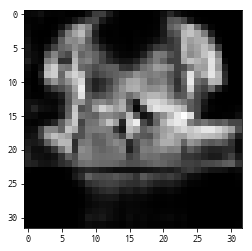

INFO:root:speed: 1182.6079846334135 samples/s
INFO:root:discriminator loss = 0.002796, generator loss = 7.884049, binary training acc = 0.985947 at iter 1500 epoch 4


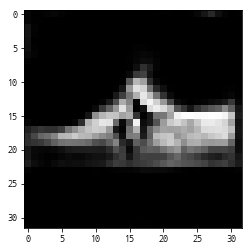

INFO:root:speed: 990.7780345028679 samples/s
INFO:root:discriminator loss = 0.006414, generator loss = 6.215785, binary training acc = 0.986815 at iter 1600 epoch 4


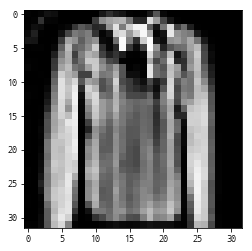

INFO:root:speed: 1219.728714364907 samples/s
INFO:root:discriminator loss = 0.013560, generator loss = 5.602900, binary training acc = 0.987581 at iter 1700 epoch 4


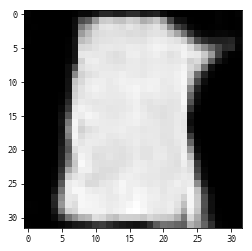

INFO:root:speed: 1233.743558631847 samples/s
INFO:root:discriminator loss = 0.272885, generator loss = 4.878680, binary training acc = 0.986900 at iter 1800 epoch 4


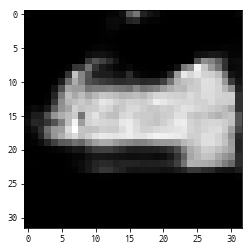

INFO:root:speed: 265.56259979541323 samples/s
INFO:root:discriminator loss = 0.139027, generator loss = 4.707169, binary training acc = 0.984375 at iter 0 epoch 5


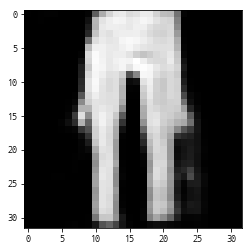

INFO:root:speed: 91.83138918708482 samples/s
INFO:root:discriminator loss = 0.368749, generator loss = 3.999020, binary training acc = 0.983447 at iter 100 epoch 5


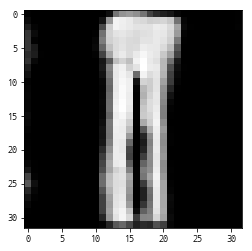

INFO:root:speed: 1125.7798728422606 samples/s
INFO:root:discriminator loss = 0.332718, generator loss = 2.512715, binary training acc = 0.955224 at iter 200 epoch 5


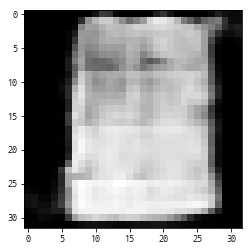

INFO:root:speed: 1371.4579062994942 samples/s
INFO:root:discriminator loss = 0.905531, generator loss = 3.507492, binary training acc = 0.950114 at iter 300 epoch 5


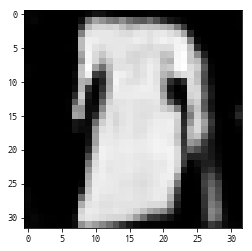

INFO:root:speed: 1078.6431786035746 samples/s
INFO:root:discriminator loss = 0.012011, generator loss = 5.835332, binary training acc = 0.961191 at iter 400 epoch 5


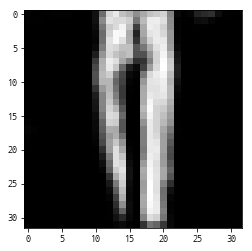

INFO:root:speed: 1318.251023915926 samples/s
INFO:root:discriminator loss = 0.027349, generator loss = 5.578647, binary training acc = 0.968812 at iter 500 epoch 5


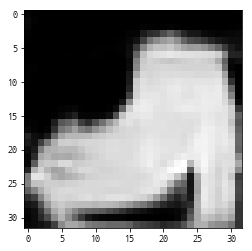

INFO:root:speed: 1327.0489222859403 samples/s
INFO:root:discriminator loss = 0.007152, generator loss = 6.185863, binary training acc = 0.973716 at iter 600 epoch 5


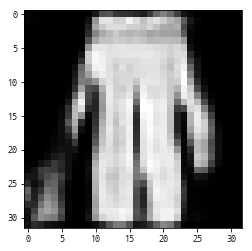

INFO:root:speed: 1299.7659180926373 samples/s
INFO:root:discriminator loss = 0.256079, generator loss = 4.778867, binary training acc = 0.969463 at iter 700 epoch 5


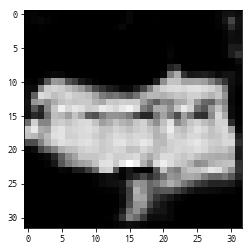

INFO:root:speed: 133.42717200586526 samples/s
INFO:root:discriminator loss = 0.069520, generator loss = 6.366352, binary training acc = 0.965668 at iter 800 epoch 5


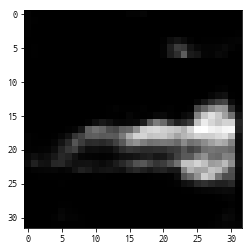

INFO:root:speed: 1364.4450227716331 samples/s
INFO:root:discriminator loss = 0.008860, generator loss = 6.249434, binary training acc = 0.968958 at iter 900 epoch 5


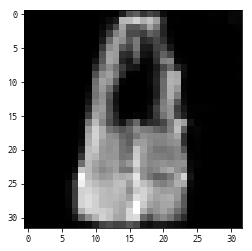

INFO:root:speed: 1057.4070006538986 samples/s
INFO:root:discriminator loss = 0.049019, generator loss = 4.350681, binary training acc = 0.966518 at iter 1000 epoch 5


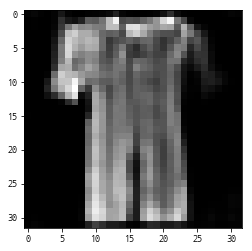

INFO:root:speed: 124.47310224457867 samples/s
INFO:root:discriminator loss = 0.031120, generator loss = 5.294739, binary training acc = 0.969403 at iter 1100 epoch 5


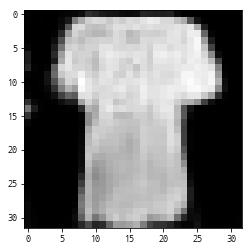

INFO:root:speed: 329.9508285785226 samples/s
INFO:root:discriminator loss = 0.038933, generator loss = 6.828463, binary training acc = 0.971872 at iter 1200 epoch 5


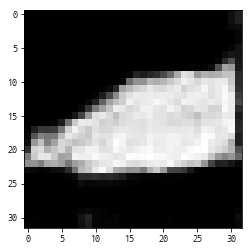

INFO:root:speed: 1368.465502299167 samples/s
INFO:root:discriminator loss = 0.057869, generator loss = 5.504023, binary training acc = 0.974022 at iter 1300 epoch 5


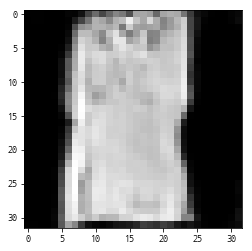

INFO:root:speed: 81.94790950531248 samples/s
INFO:root:discriminator loss = 0.170977, generator loss = 5.942358, binary training acc = 0.972352 at iter 1400 epoch 5


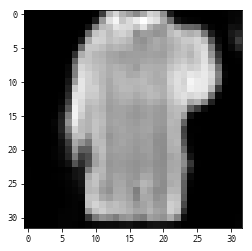

INFO:root:speed: 810.8656629854281 samples/s
INFO:root:discriminator loss = 0.041413, generator loss = 5.283218, binary training acc = 0.968833 at iter 1500 epoch 5


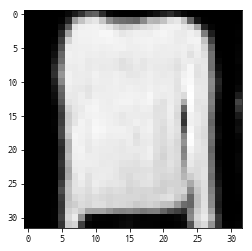

INFO:root:speed: 694.989322811487 samples/s
INFO:root:discriminator loss = 0.019621, generator loss = 5.513136, binary training acc = 0.970272 at iter 1600 epoch 5


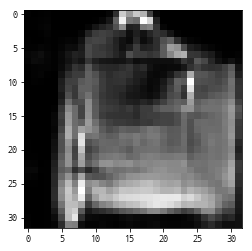

INFO:root:speed: 1371.9625877807193 samples/s
INFO:root:discriminator loss = 0.006516, generator loss = 6.123118, binary training acc = 0.972002 at iter 1700 epoch 5


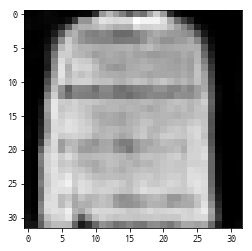

INFO:root:speed: 1380.0173558987435 samples/s
INFO:root:discriminator loss = 0.482189, generator loss = 3.015089, binary training acc = 0.971387 at iter 1800 epoch 5


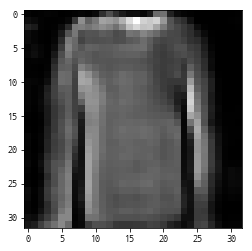

INFO:root:speed: 193.8324480606318 samples/s
INFO:root:discriminator loss = 0.054648, generator loss = 5.530425, binary training acc = 1.000000 at iter 0 epoch 6


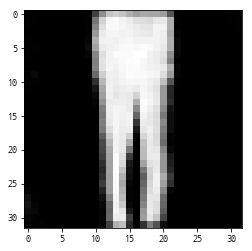

INFO:root:speed: 1254.51198265226 samples/s
INFO:root:discriminator loss = 0.033464, generator loss = 5.564408, binary training acc = 0.990254 at iter 100 epoch 6


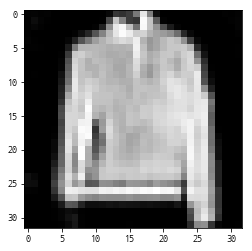

INFO:root:speed: 1157.6481628428498 samples/s
INFO:root:discriminator loss = 0.012572, generator loss = 6.837477, binary training acc = 0.994014 at iter 200 epoch 6


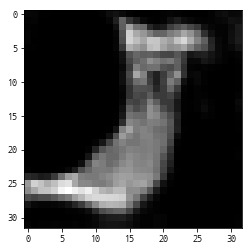

INFO:root:speed: 1026.3962192007098 samples/s
INFO:root:discriminator loss = 0.008203, generator loss = 6.166734, binary training acc = 0.996003 at iter 300 epoch 6


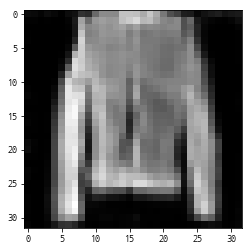

INFO:root:speed: 1174.2172452407615 samples/s
INFO:root:discriminator loss = 0.460351, generator loss = 4.202669, binary training acc = 0.988427 at iter 400 epoch 6


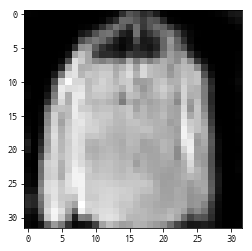

INFO:root:speed: 1256.0499358956363 samples/s
INFO:root:discriminator loss = 0.054198, generator loss = 5.225737, binary training acc = 0.985435 at iter 500 epoch 6


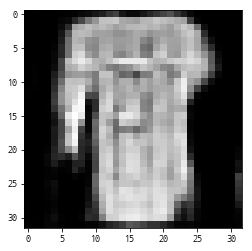

INFO:root:speed: 798.0742194235835 samples/s
INFO:root:discriminator loss = 0.038014, generator loss = 6.171746, binary training acc = 0.987729 at iter 600 epoch 6


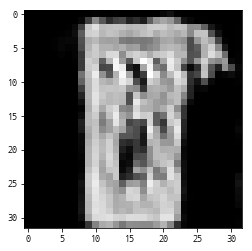

INFO:root:speed: 957.289474059598 samples/s
INFO:root:discriminator loss = 0.004611, generator loss = 6.312920, binary training acc = 0.989390 at iter 700 epoch 6


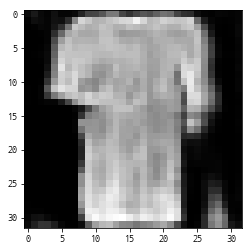

INFO:root:speed: 1323.7637265635017 samples/s
INFO:root:discriminator loss = 0.078401, generator loss = 4.913131, binary training acc = 0.983185 at iter 800 epoch 6


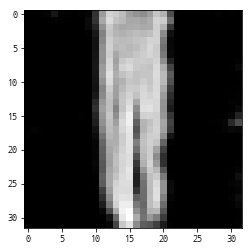

INFO:root:speed: 1070.7949961705388 samples/s
INFO:root:discriminator loss = 1.974014, generator loss = 0.255174, binary training acc = 0.984046 at iter 900 epoch 6


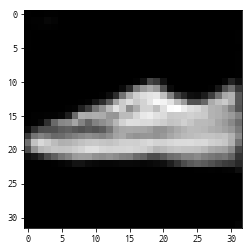

INFO:root:speed: 1079.649666977702 samples/s
INFO:root:discriminator loss = 0.061298, generator loss = 4.598609, binary training acc = 0.978771 at iter 1000 epoch 6


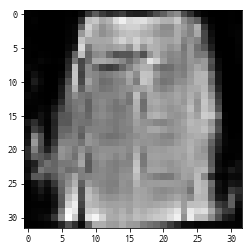

INFO:root:speed: 1067.3038471937275 samples/s
INFO:root:discriminator loss = 0.051319, generator loss = 4.662998, binary training acc = 0.978613 at iter 1100 epoch 6


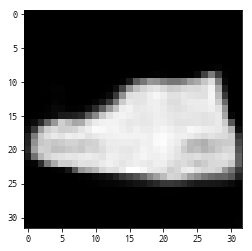

INFO:root:speed: 955.1299644897988 samples/s
INFO:root:discriminator loss = 0.006224, generator loss = 6.577132, binary training acc = 0.980264 at iter 1200 epoch 6


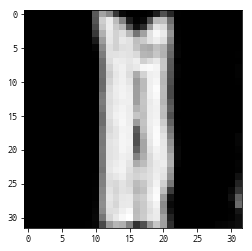

INFO:root:speed: 1348.542400128607 samples/s
INFO:root:discriminator loss = 0.005757, generator loss = 6.940683, binary training acc = 0.981781 at iter 1300 epoch 6


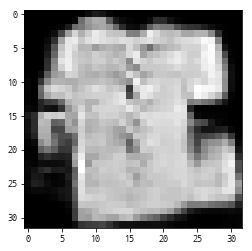

INFO:root:speed: 1197.6454295606238 samples/s
INFO:root:discriminator loss = 0.002833, generator loss = 7.005106, binary training acc = 0.983070 at iter 1400 epoch 6


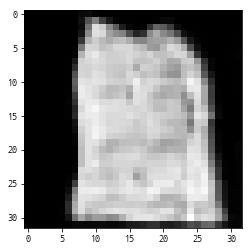

INFO:root:speed: 1070.0864088274454 samples/s
INFO:root:discriminator loss = 0.004275, generator loss = 7.127872, binary training acc = 0.984188 at iter 1500 epoch 6


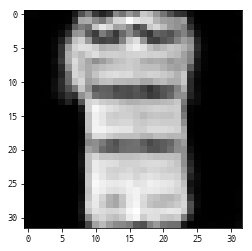

INFO:root:speed: 1160.801971891892 samples/s
INFO:root:discriminator loss = 0.001527, generator loss = 7.929548, binary training acc = 0.985175 at iter 1600 epoch 6


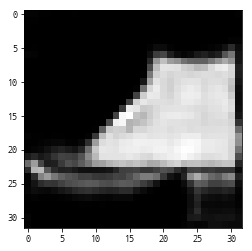

INFO:root:speed: 1198.5116843919384 samples/s
INFO:root:discriminator loss = 0.004192, generator loss = 6.560206, binary training acc = 0.986047 at iter 1700 epoch 6


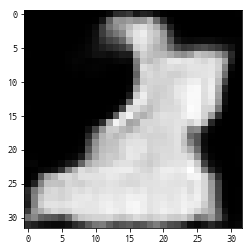

INFO:root:speed: 695.2917456666563 samples/s
INFO:root:discriminator loss = 0.005404, generator loss = 7.021720, binary training acc = 0.986804 at iter 1800 epoch 6


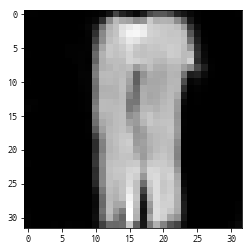

INFO:root:speed: 303.25247969922776 samples/s
INFO:root:discriminator loss = 0.008174, generator loss = 6.375833, binary training acc = 1.000000 at iter 0 epoch 7


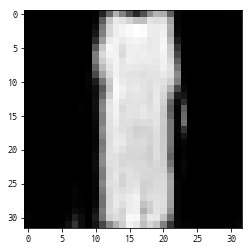

INFO:root:speed: 696.0272980905856 samples/s
INFO:root:discriminator loss = 0.000553, generator loss = 8.745518, binary training acc = 1.000000 at iter 100 epoch 7


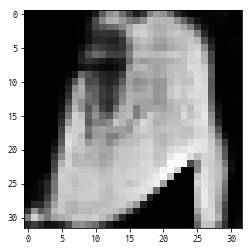

INFO:root:speed: 839.1912315474218 samples/s
INFO:root:discriminator loss = 0.003222, generator loss = 7.793416, binary training acc = 1.000000 at iter 200 epoch 7


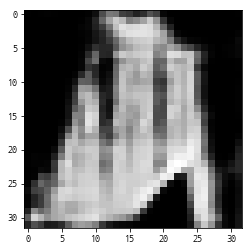

INFO:root:speed: 279.64240502373104 samples/s
INFO:root:discriminator loss = 0.002342, generator loss = 8.024223, binary training acc = 1.000000 at iter 300 epoch 7


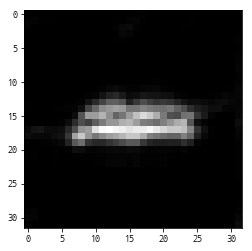

INFO:root:speed: 832.3734891191774 samples/s
INFO:root:discriminator loss = 0.002355, generator loss = 7.923558, binary training acc = 0.999961 at iter 400 epoch 7


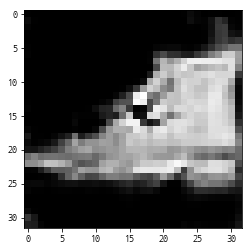

INFO:root:speed: 1297.4540392664842 samples/s
INFO:root:discriminator loss = 0.003731, generator loss = 7.009610, binary training acc = 0.999969 at iter 500 epoch 7


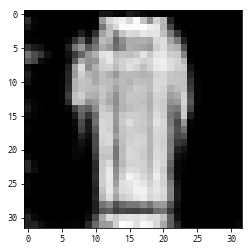

INFO:root:speed: 589.6000210857399 samples/s
INFO:root:discriminator loss = 0.001935, generator loss = 7.806861, binary training acc = 0.999948 at iter 600 epoch 7


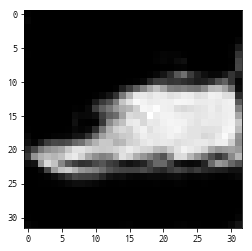

INFO:root:speed: 1369.3171458303577 samples/s
INFO:root:discriminator loss = 0.002783, generator loss = 7.518143, binary training acc = 0.999955 at iter 700 epoch 7


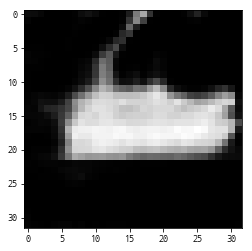

INFO:root:speed: 1341.9357315683178 samples/s
INFO:root:discriminator loss = 0.001201, generator loss = 7.756275, binary training acc = 0.999922 at iter 800 epoch 7


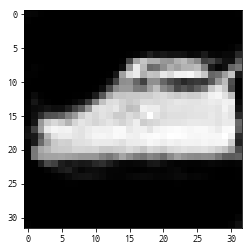

INFO:root:speed: 1229.1338406732787 samples/s
INFO:root:discriminator loss = 0.001249, generator loss = 8.991359, binary training acc = 0.999931 at iter 900 epoch 7


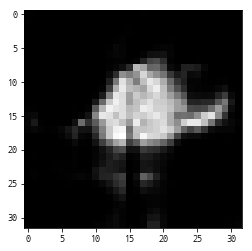

INFO:root:speed: 1234.2541013757082 samples/s
INFO:root:discriminator loss = 0.001170, generator loss = 6.970397, binary training acc = 0.999938 at iter 1000 epoch 7


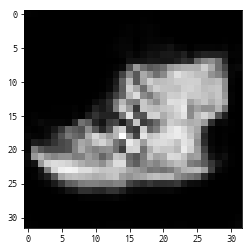

INFO:root:speed: 1407.3960111570161 samples/s
INFO:root:discriminator loss = 0.001100, generator loss = 7.987268, binary training acc = 0.999915 at iter 1100 epoch 7


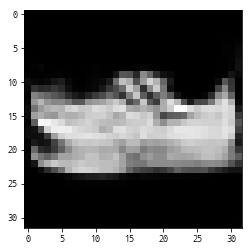

INFO:root:speed: 1039.5449532189107 samples/s
INFO:root:discriminator loss = 0.035978, generator loss = 4.598203, binary training acc = 0.997034 at iter 1200 epoch 7


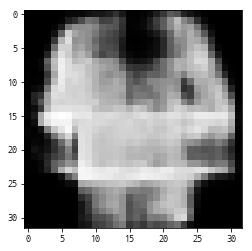

INFO:root:speed: 1283.569496777155 samples/s
INFO:root:discriminator loss = 0.118817, generator loss = 4.464535, binary training acc = 0.994932 at iter 1300 epoch 7


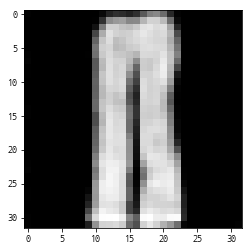

INFO:root:speed: 1322.042571634014 samples/s
INFO:root:discriminator loss = 0.130766, generator loss = 8.144577, binary training acc = 0.994357 at iter 1400 epoch 7


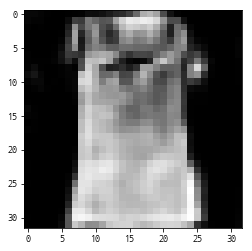

INFO:root:speed: 1218.6544635723105 samples/s
INFO:root:discriminator loss = 0.131516, generator loss = 7.086965, binary training acc = 0.993369 at iter 1500 epoch 7


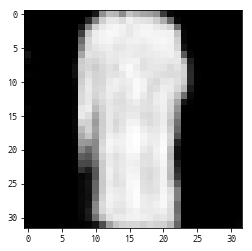

INFO:root:speed: 860.6955707607365 samples/s
INFO:root:discriminator loss = 0.110816, generator loss = 7.282039, binary training acc = 0.993305 at iter 1600 epoch 7


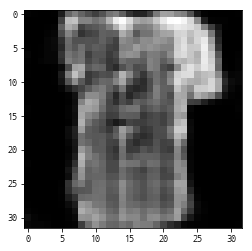

INFO:root:speed: 1301.088892766436 samples/s
INFO:root:discriminator loss = 0.601536, generator loss = 5.370973, binary training acc = 0.990291 at iter 1700 epoch 7


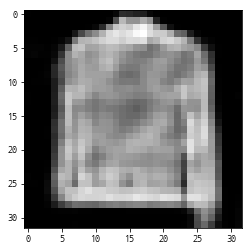

INFO:root:speed: 852.7228762571553 samples/s
INFO:root:discriminator loss = 0.023734, generator loss = 6.377088, binary training acc = 0.989797 at iter 1800 epoch 7


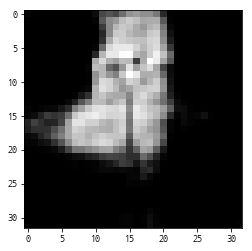

INFO:root:speed: 197.6490352260662 samples/s
INFO:root:discriminator loss = 0.008740, generator loss = 6.319340, binary training acc = 1.000000 at iter 0 epoch 8


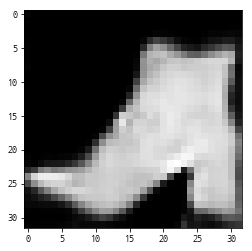

INFO:root:speed: 1227.1559525659898 samples/s
INFO:root:discriminator loss = 0.111033, generator loss = 6.496826, binary training acc = 0.961015 at iter 100 epoch 8


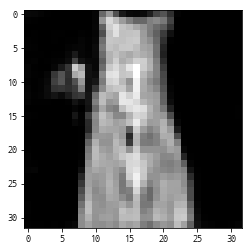

INFO:root:speed: 1052.283655693106 samples/s
INFO:root:discriminator loss = 0.021627, generator loss = 5.612975, binary training acc = 0.976524 at iter 200 epoch 8


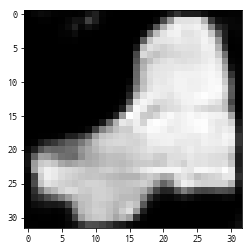

INFO:root:speed: 540.2550697569576 samples/s
INFO:root:discriminator loss = 0.004388, generator loss = 6.696367, binary training acc = 0.983648 at iter 300 epoch 8


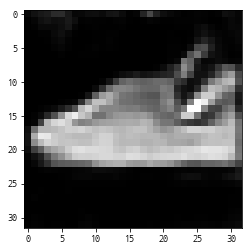

INFO:root:speed: 1068.3573031919127 samples/s
INFO:root:discriminator loss = 0.245265, generator loss = 4.815799, binary training acc = 0.979465 at iter 400 epoch 8


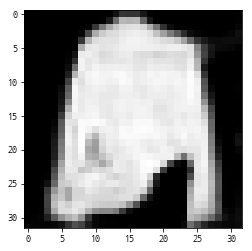

INFO:root:speed: 1220.249909084297 samples/s
INFO:root:discriminator loss = 0.207878, generator loss = 4.277646, binary training acc = 0.971900 at iter 500 epoch 8


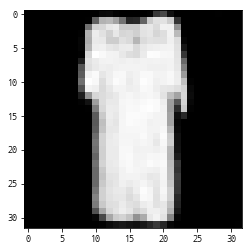

INFO:root:speed: 1080.4579506210605 samples/s
INFO:root:discriminator loss = 0.091385, generator loss = 6.252692, binary training acc = 0.968984 at iter 600 epoch 8


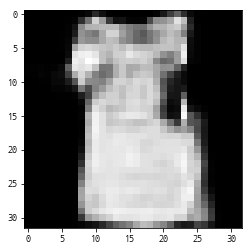

INFO:root:speed: 1022.1362109800398 samples/s
INFO:root:discriminator loss = 0.059049, generator loss = 4.855743, binary training acc = 0.966744 at iter 700 epoch 8


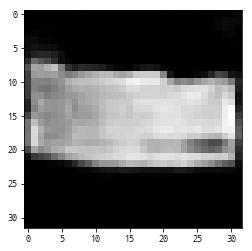

INFO:root:speed: 334.59574107405507 samples/s
INFO:root:discriminator loss = 0.052081, generator loss = 4.921442, binary training acc = 0.970564 at iter 800 epoch 8


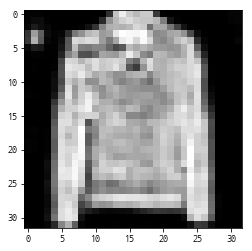

INFO:root:speed: 1193.0994977554558 samples/s
INFO:root:discriminator loss = 0.018940, generator loss = 6.706247, binary training acc = 0.973831 at iter 900 epoch 8


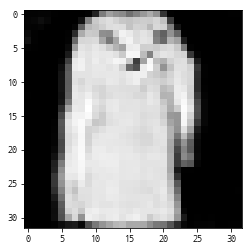

INFO:root:speed: 1061.4712167345485 samples/s
INFO:root:discriminator loss = 0.002142, generator loss = 7.560363, binary training acc = 0.976414 at iter 1000 epoch 8


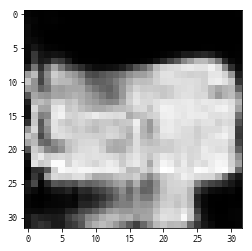

INFO:root:speed: 795.3925946996634 samples/s
INFO:root:discriminator loss = 0.005628, generator loss = 6.198972, binary training acc = 0.978542 at iter 1100 epoch 8


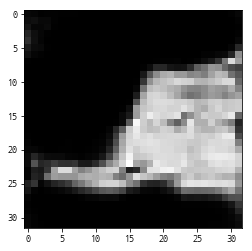

INFO:root:speed: 1147.4935280337877 samples/s
INFO:root:discriminator loss = 0.005704, generator loss = 6.721912, binary training acc = 0.980329 at iter 1200 epoch 8


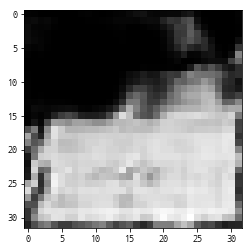

INFO:root:speed: 898.4445173339402 samples/s
INFO:root:discriminator loss = 0.008553, generator loss = 6.957754, binary training acc = 0.981793 at iter 1300 epoch 8


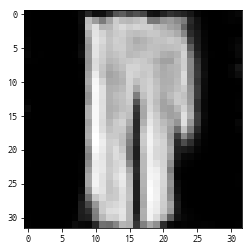

INFO:root:speed: 1142.5216258778464 samples/s
INFO:root:discriminator loss = 0.002487, generator loss = 6.840667, binary training acc = 0.983070 at iter 1400 epoch 8


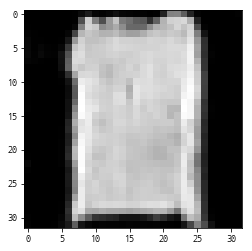

INFO:root:speed: 1403.3199293204939 samples/s
INFO:root:discriminator loss = 0.003275, generator loss = 7.214801, binary training acc = 0.984188 at iter 1500 epoch 8


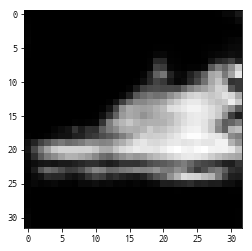

INFO:root:speed: 709.5422840860431 samples/s
INFO:root:discriminator loss = 0.012991, generator loss = 7.964578, binary training acc = 0.985166 at iter 1600 epoch 8


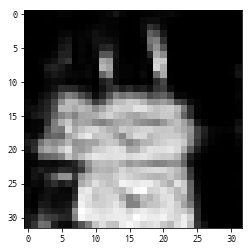

INFO:root:speed: 1030.2013923535687 samples/s
INFO:root:discriminator loss = 0.060184, generator loss = 5.601541, binary training acc = 0.984770 at iter 1700 epoch 8


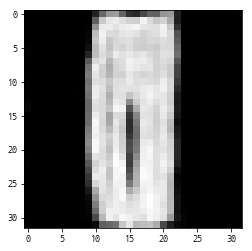

INFO:root:speed: 793.3240022697182 samples/s
INFO:root:discriminator loss = 0.008452, generator loss = 6.415682, binary training acc = 0.985347 at iter 1800 epoch 8


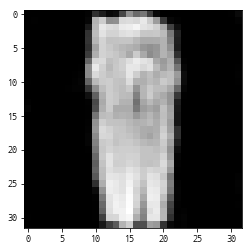

INFO:root:speed: 364.78850225448656 samples/s
INFO:root:discriminator loss = 0.044732, generator loss = 7.941164, binary training acc = 0.984375 at iter 0 epoch 9


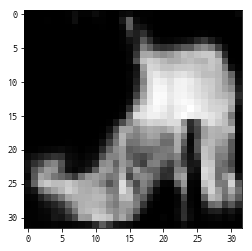

INFO:root:speed: 1205.2597701149425 samples/s
INFO:root:discriminator loss = 0.007898, generator loss = 6.325464, binary training acc = 0.998144 at iter 100 epoch 9


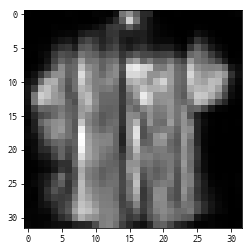

INFO:root:speed: 1367.7821620740258 samples/s
INFO:root:discriminator loss = 0.007232, generator loss = 7.786035, binary training acc = 0.998989 at iter 200 epoch 9


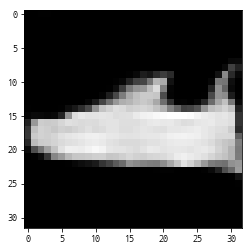

INFO:root:speed: 1262.583985550873 samples/s
INFO:root:discriminator loss = 0.112732, generator loss = 5.076959, binary training acc = 0.979392 at iter 300 epoch 9


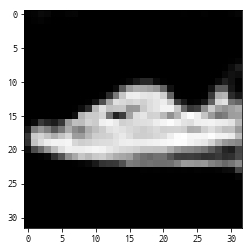

INFO:root:speed: 1135.3024648542573 samples/s
INFO:root:discriminator loss = 0.197073, generator loss = 4.297431, binary training acc = 0.971439 at iter 400 epoch 9


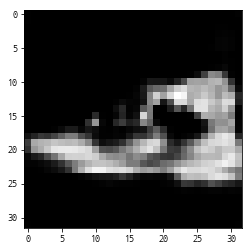

INFO:root:speed: 842.3777270102679 samples/s
INFO:root:discriminator loss = 0.170211, generator loss = 6.308440, binary training acc = 0.969280 at iter 500 epoch 9


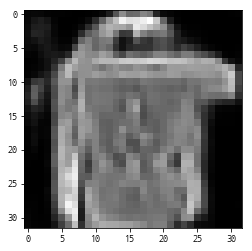

INFO:root:speed: 1185.239692337581 samples/s
INFO:root:discriminator loss = 4.271728, generator loss = 2.923828, binary training acc = 0.968568 at iter 600 epoch 9


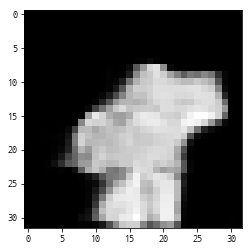

INFO:root:speed: 1071.1624647847982 samples/s
INFO:root:discriminator loss = 0.096012, generator loss = 5.489919, binary training acc = 0.967881 at iter 700 epoch 9


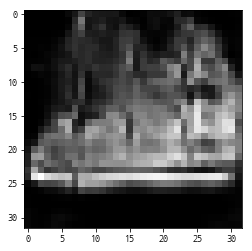

INFO:root:speed: 803.121876495931 samples/s
INFO:root:discriminator loss = 0.037991, generator loss = 5.245163, binary training acc = 0.971793 at iter 800 epoch 9


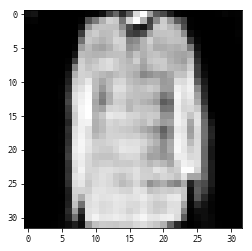

INFO:root:speed: 1129.4270976211112 samples/s
INFO:root:discriminator loss = 0.493023, generator loss = 4.421383, binary training acc = 0.967657 at iter 900 epoch 9


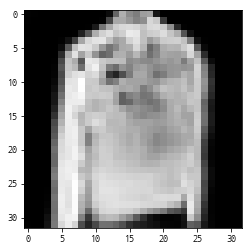

INFO:root:speed: 958.8624335600389 samples/s
INFO:root:discriminator loss = 0.443807, generator loss = 2.538033, binary training acc = 0.964395 at iter 1000 epoch 9


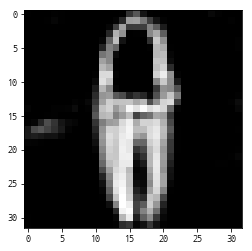

INFO:root:speed: 933.5521628144758 samples/s
INFO:root:discriminator loss = 0.011632, generator loss = 6.286110, binary training acc = 0.966891 at iter 1100 epoch 9


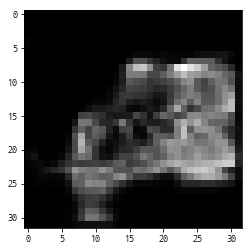

INFO:root:speed: 686.0268752076465 samples/s
INFO:root:discriminator loss = 0.167427, generator loss = 3.906007, binary training acc = 0.964704 at iter 1200 epoch 9


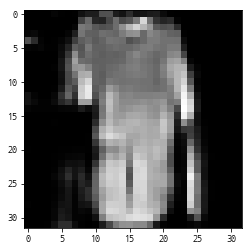

INFO:root:speed: 1021.0398320299425 samples/s
INFO:root:discriminator loss = 0.062575, generator loss = 5.439694, binary training acc = 0.964583 at iter 1300 epoch 9


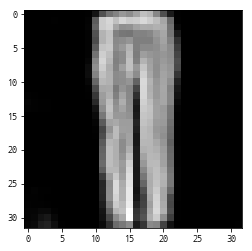

INFO:root:speed: 1082.1392243811981 samples/s
INFO:root:discriminator loss = 0.014182, generator loss = 5.558205, binary training acc = 0.967010 at iter 1400 epoch 9


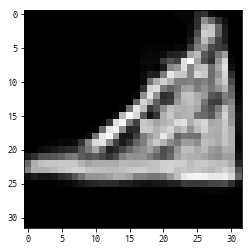

INFO:root:speed: 619.7629696670253 samples/s
INFO:root:discriminator loss = 0.006732, generator loss = 6.783145, binary training acc = 0.969166 at iter 1500 epoch 9


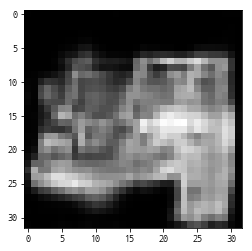

INFO:root:speed: 1055.3948400997067 samples/s
INFO:root:discriminator loss = 0.014591, generator loss = 5.782550, binary training acc = 0.968740 at iter 1600 epoch 9


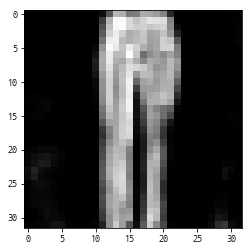

INFO:root:speed: 1021.506088650755 samples/s
INFO:root:discriminator loss = 0.007412, generator loss = 6.131804, binary training acc = 0.970523 at iter 1700 epoch 9


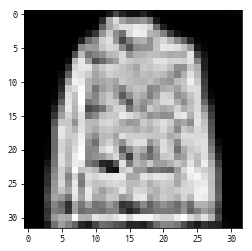

INFO:root:speed: 959.1365195517951 samples/s
INFO:root:discriminator loss = 0.025834, generator loss = 6.485397, binary training acc = 0.972099 at iter 1800 epoch 9


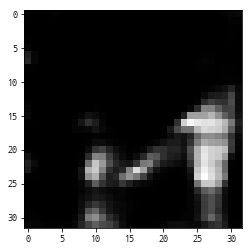

INFO:root:speed: 69.90412004837434 samples/s
INFO:root:discriminator loss = 0.004269, generator loss = 7.445847, binary training acc = 1.000000 at iter 0 epoch 10


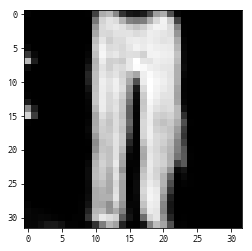

INFO:root:speed: 1141.5693058780503 samples/s
INFO:root:discriminator loss = 0.059576, generator loss = 4.629076, binary training acc = 0.968441 at iter 100 epoch 10


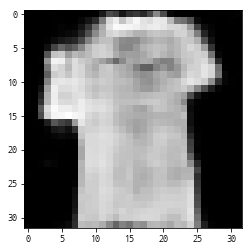

INFO:root:speed: 1230.75686134265 samples/s
INFO:root:discriminator loss = 0.006355, generator loss = 6.701416, binary training acc = 0.979711 at iter 200 epoch 10


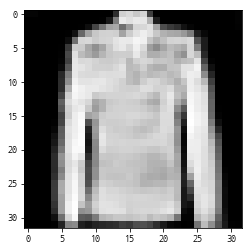

INFO:root:speed: 912.8222204086074 samples/s
INFO:root:discriminator loss = 0.024574, generator loss = 6.116325, binary training acc = 0.986400 at iter 300 epoch 10


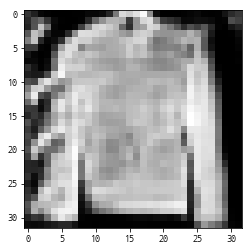

INFO:root:speed: 1148.6031851984972 samples/s
INFO:root:discriminator loss = 0.003239, generator loss = 7.342499, binary training acc = 0.989674 at iter 400 epoch 10


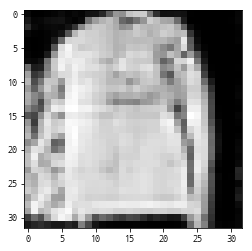

INFO:root:speed: 1204.7404854229499 samples/s
INFO:root:discriminator loss = 0.013267, generator loss = 6.636837, binary training acc = 0.991673 at iter 500 epoch 10


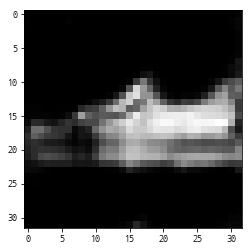

INFO:root:speed: 1118.919310063108 samples/s
INFO:root:discriminator loss = 0.008402, generator loss = 6.899206, binary training acc = 0.992902 at iter 600 epoch 10


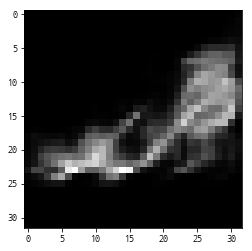

INFO:root:speed: 391.66616474653034 samples/s
INFO:root:discriminator loss = 0.002351, generator loss = 7.384283, binary training acc = 0.993893 at iter 700 epoch 10


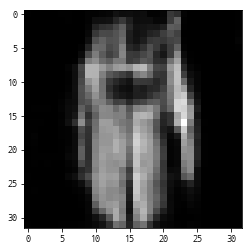

INFO:root:speed: 1216.5667618400182 samples/s
INFO:root:discriminator loss = 0.092237, generator loss = 5.854300, binary training acc = 0.991768 at iter 800 epoch 10


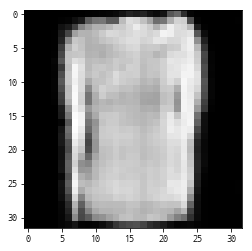

INFO:root:speed: 1193.6618701197062 samples/s
INFO:root:discriminator loss = 0.037764, generator loss = 5.557061, binary training acc = 0.992127 at iter 900 epoch 10


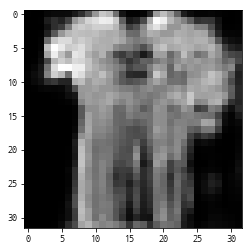

INFO:root:speed: 1152.2219665882594 samples/s
INFO:root:discriminator loss = 0.102001, generator loss = 4.464204, binary training acc = 0.991196 at iter 1000 epoch 10


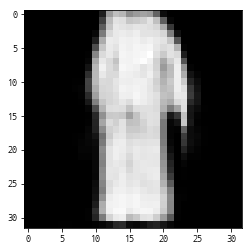

INFO:root:speed: 1215.9826052293029 samples/s
INFO:root:discriminator loss = 0.027249, generator loss = 5.194841, binary training acc = 0.990208 at iter 1100 epoch 10


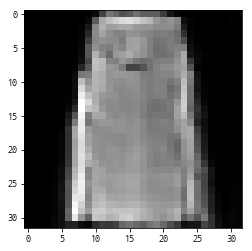

INFO:root:speed: 1272.6040183185262 samples/s
INFO:root:discriminator loss = 0.005298, generator loss = 6.183744, binary training acc = 0.990841 at iter 1200 epoch 10


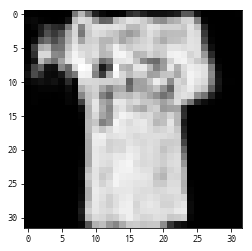

INFO:root:speed: 787.9771739896203 samples/s
INFO:root:discriminator loss = 0.227305, generator loss = 5.960850, binary training acc = 0.990380 at iter 1300 epoch 10


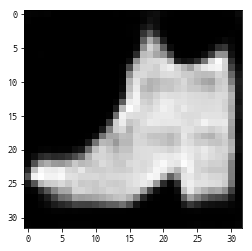

INFO:root:speed: 1036.13429367671 samples/s
INFO:root:discriminator loss = 0.149680, generator loss = 4.477967, binary training acc = 0.988858 at iter 1400 epoch 10


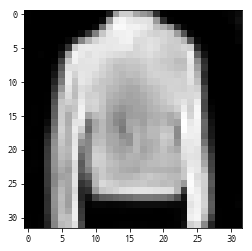

INFO:root:speed: 909.4081361628316 samples/s
INFO:root:discriminator loss = 0.026170, generator loss = 5.600644, binary training acc = 0.988997 at iter 1500 epoch 10


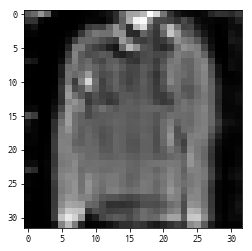

INFO:root:speed: 1120.3015566962981 samples/s
INFO:root:discriminator loss = 0.004295, generator loss = 6.664265, binary training acc = 0.989665 at iter 1600 epoch 10


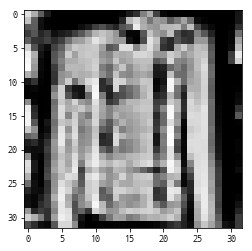

INFO:root:speed: 933.5002190862365 samples/s
INFO:root:discriminator loss = 0.007451, generator loss = 7.678179, binary training acc = 0.990245 at iter 1700 epoch 10


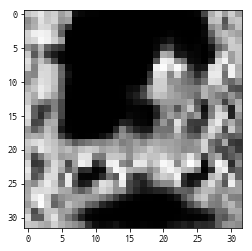

INFO:root:speed: 852.8474989833265 samples/s
INFO:root:discriminator loss = 0.003042, generator loss = 7.086875, binary training acc = 0.990778 at iter 1800 epoch 10


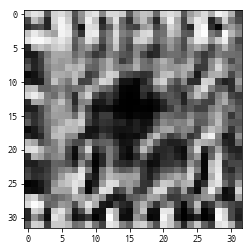

INFO:root:speed: 464.2525310873212 samples/s
INFO:root:discriminator loss = 0.012754, generator loss = 6.719521, binary training acc = 1.000000 at iter 0 epoch 11


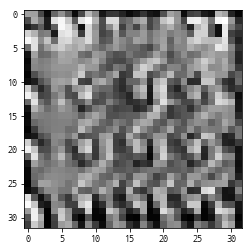

INFO:root:speed: 1189.5887331932959 samples/s
INFO:root:discriminator loss = 0.004431, generator loss = 7.188765, binary training acc = 0.999691 at iter 100 epoch 11


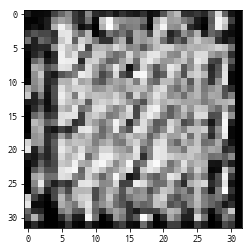

INFO:root:speed: 1224.5249251879425 samples/s
INFO:root:discriminator loss = 0.007870, generator loss = 6.997721, binary training acc = 0.999689 at iter 200 epoch 11


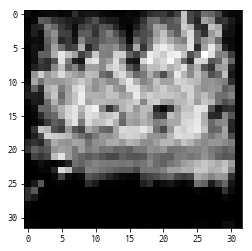

INFO:root:speed: 1324.2208453372273 samples/s
INFO:root:discriminator loss = 0.001824, generator loss = 9.575005, binary training acc = 0.999740 at iter 300 epoch 11


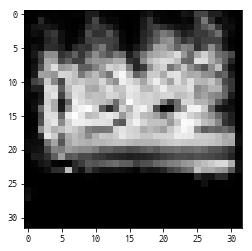

INFO:root:speed: 1413.3388932764703 samples/s
INFO:root:discriminator loss = 0.001464, generator loss = 7.598097, binary training acc = 0.999805 at iter 400 epoch 11


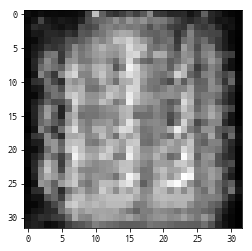

INFO:root:speed: 121.25770453888407 samples/s
INFO:root:discriminator loss = 0.000379, generator loss = 8.942875, binary training acc = 0.999782 at iter 500 epoch 11


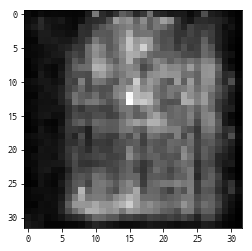

INFO:root:speed: 1186.9481950512036 samples/s
INFO:root:discriminator loss = 0.008132, generator loss = 11.777569, binary training acc = 0.999818 at iter 600 epoch 11


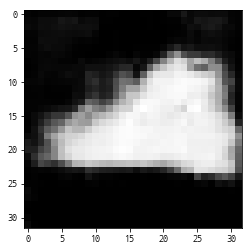

INFO:root:speed: 1280.9724178739812 samples/s
INFO:root:discriminator loss = 0.006652, generator loss = 7.049720, binary training acc = 0.997102 at iter 700 epoch 11


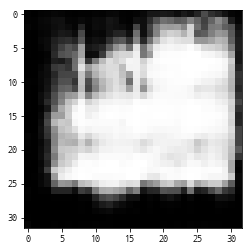

INFO:root:speed: 1361.8975566198555 samples/s
INFO:root:discriminator loss = 0.023428, generator loss = 5.865711, binary training acc = 0.997250 at iter 800 epoch 11


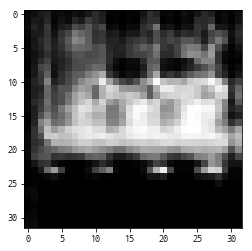

INFO:root:speed: 1089.049503825775 samples/s
INFO:root:discriminator loss = 0.015875, generator loss = 7.380953, binary training acc = 0.997381 at iter 900 epoch 11


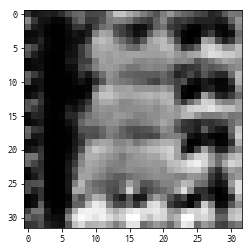

INFO:root:speed: 1248.1074234914495 samples/s
INFO:root:discriminator loss = 0.047423, generator loss = 6.803354, binary training acc = 0.997518 at iter 1000 epoch 11


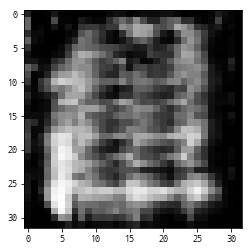

INFO:root:speed: 1204.967617405981 samples/s
INFO:root:discriminator loss = 0.006668, generator loss = 6.184414, binary training acc = 0.997559 at iter 1100 epoch 11


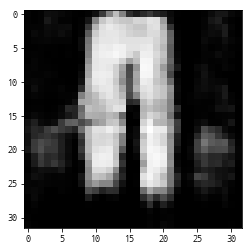

INFO:root:speed: 246.70970588073106 samples/s
INFO:root:discriminator loss = 0.003558, generator loss = 10.472645, binary training acc = 0.997684 at iter 1200 epoch 11


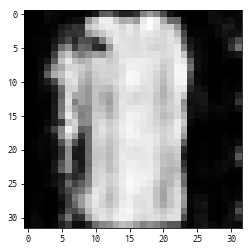

INFO:root:speed: 1198.8435456786594 samples/s
INFO:root:discriminator loss = 0.001634, generator loss = 7.973202, binary training acc = 0.997814 at iter 1300 epoch 11


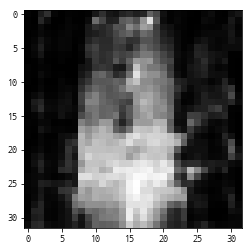

INFO:root:speed: 1171.358124678181 samples/s
INFO:root:discriminator loss = 0.003028, generator loss = 7.035524, binary training acc = 0.997926 at iter 1400 epoch 11


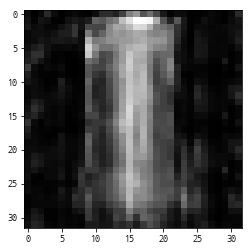

INFO:root:speed: 293.48241962005386 samples/s
INFO:root:discriminator loss = 0.060004, generator loss = 6.293792, binary training acc = 0.997117 at iter 1500 epoch 11


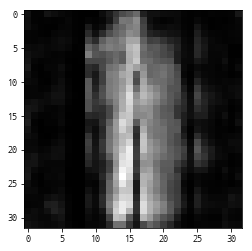

INFO:root:speed: 1045.9203428794078 samples/s
INFO:root:discriminator loss = 0.003998, generator loss = 7.360589, binary training acc = 0.996818 at iter 1600 epoch 11


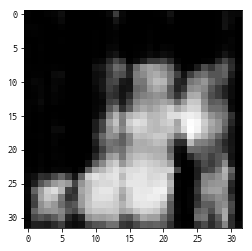

INFO:root:speed: 1061.9667368221164 samples/s
INFO:root:discriminator loss = 0.163399, generator loss = 9.220737, binary training acc = 0.996565 at iter 1700 epoch 11


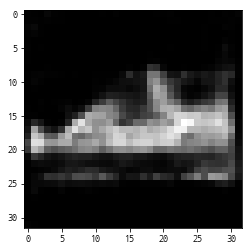

INFO:root:speed: 672.676155727517 samples/s
INFO:root:discriminator loss = 0.016700, generator loss = 6.874928, binary training acc = 0.996634 at iter 1800 epoch 11


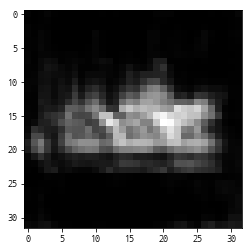

INFO:root:speed: 358.5344449460533 samples/s
INFO:root:discriminator loss = 0.035688, generator loss = 5.844840, binary training acc = 0.984375 at iter 0 epoch 12


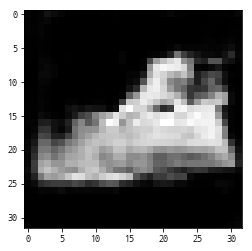

INFO:root:speed: 296.85255763752497 samples/s
INFO:root:discriminator loss = 0.024386, generator loss = 7.035825, binary training acc = 0.984375 at iter 100 epoch 12


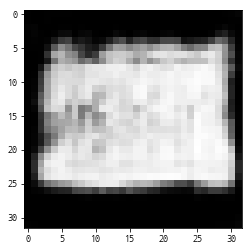

INFO:root:speed: 1240.4825227823064 samples/s
INFO:root:discriminator loss = 0.139339, generator loss = 3.946277, binary training acc = 0.991060 at iter 200 epoch 12


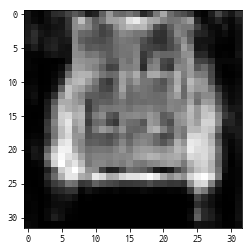

INFO:root:speed: 1091.8224029935736 samples/s
INFO:root:discriminator loss = 0.000895, generator loss = 8.310081, binary training acc = 0.993823 at iter 300 epoch 12


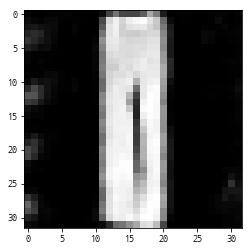

INFO:root:speed: 1280.605755285856 samples/s
INFO:root:discriminator loss = 0.001686, generator loss = 7.950599, binary training acc = 0.995363 at iter 400 epoch 12


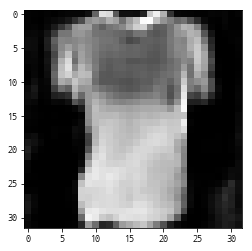

INFO:root:speed: 1398.9465301953264 samples/s
INFO:root:discriminator loss = 0.246730, generator loss = 9.671345, binary training acc = 0.996133 at iter 500 epoch 12


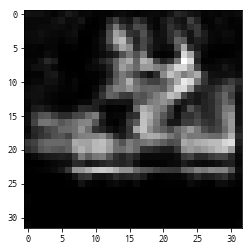

INFO:root:speed: 1045.2117247609258 samples/s
INFO:root:discriminator loss = 0.002856, generator loss = 7.614737, binary training acc = 0.993552 at iter 600 epoch 12


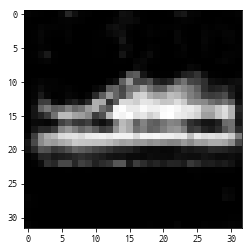

INFO:root:speed: 1334.1589845031363 samples/s
INFO:root:discriminator loss = 0.037058, generator loss = 5.640896, binary training acc = 0.993536 at iter 700 epoch 12


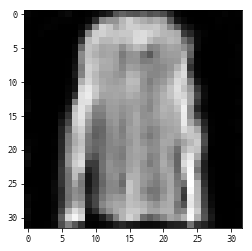

INFO:root:speed: 1083.169733359158 samples/s
INFO:root:discriminator loss = 0.124108, generator loss = 5.052893, binary training acc = 0.992392 at iter 800 epoch 12


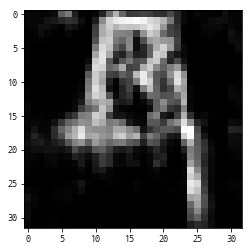

INFO:root:speed: 920.9268982173978 samples/s
INFO:root:discriminator loss = 0.169766, generator loss = 9.493477, binary training acc = 0.992959 at iter 900 epoch 12


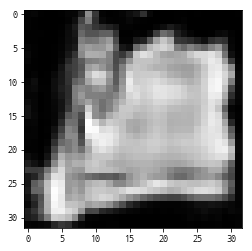

INFO:root:speed: 1092.071146116418 samples/s
INFO:root:discriminator loss = 0.027285, generator loss = 6.038810, binary training acc = 0.993569 at iter 1000 epoch 12


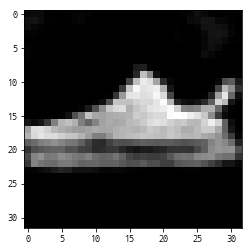

INFO:root:speed: 1067.0832246780092 samples/s
INFO:root:discriminator loss = 0.008577, generator loss = 8.567813, binary training acc = 0.988874 at iter 1100 epoch 12


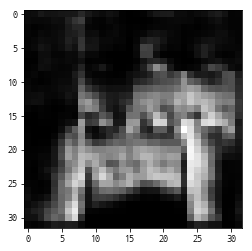

INFO:root:speed: 977.0384648982325 samples/s
INFO:root:discriminator loss = 0.174970, generator loss = 5.123215, binary training acc = 0.987588 at iter 1200 epoch 12


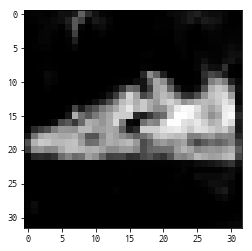

INFO:root:speed: 1358.7540797732333 samples/s
INFO:root:discriminator loss = 0.050134, generator loss = 7.410434, binary training acc = 0.987606 at iter 1300 epoch 12


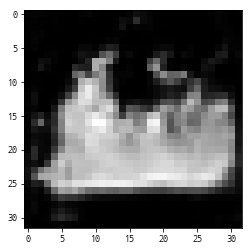

INFO:root:speed: 1388.770531325987 samples/s
INFO:root:discriminator loss = 0.033184, generator loss = 5.743477, binary training acc = 0.987096 at iter 1400 epoch 12


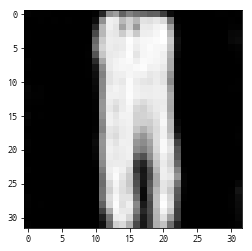

INFO:root:speed: 739.6057132780815 samples/s
INFO:root:discriminator loss = 0.053484, generator loss = 6.303310, binary training acc = 0.986072 at iter 1500 epoch 12


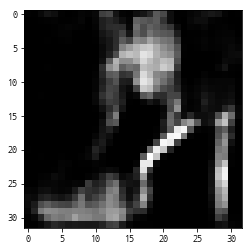

INFO:root:speed: 585.4695700725852 samples/s
INFO:root:discriminator loss = 0.189528, generator loss = 7.795940, binary training acc = 0.986444 at iter 1600 epoch 12


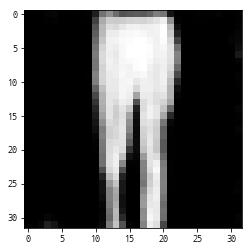

INFO:root:speed: 761.3851067330002 samples/s
INFO:root:discriminator loss = 0.026888, generator loss = 6.260905, binary training acc = 0.987158 at iter 1700 epoch 12


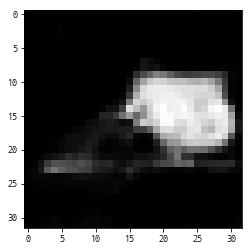

INFO:root:speed: 1178.0305088911125 samples/s
INFO:root:discriminator loss = 0.284421, generator loss = 8.589991, binary training acc = 0.987377 at iter 1800 epoch 12


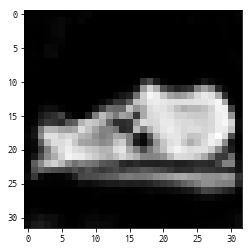

INFO:root:speed: 170.6601564983432 samples/s
INFO:root:discriminator loss = 0.012446, generator loss = 6.057952, binary training acc = 1.000000 at iter 0 epoch 13


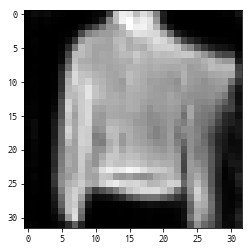

INFO:root:speed: 1128.923610059719 samples/s
INFO:root:discriminator loss = 0.007469, generator loss = 7.070497, binary training acc = 0.980817 at iter 100 epoch 13


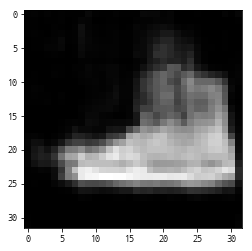

INFO:root:speed: 1073.4841877949293 samples/s
INFO:root:discriminator loss = 0.079252, generator loss = 7.000147, binary training acc = 0.987795 at iter 200 epoch 13


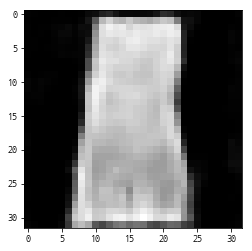

INFO:root:speed: 930.929752524692 samples/s
INFO:root:discriminator loss = 0.011478, generator loss = 8.034970, binary training acc = 0.991694 at iter 300 epoch 13


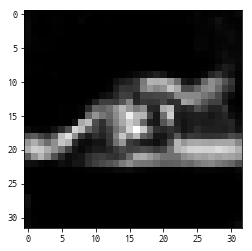

INFO:root:speed: 1048.0519740129935 samples/s
INFO:root:discriminator loss = 0.219018, generator loss = 3.740309, binary training acc = 0.987375 at iter 400 epoch 13


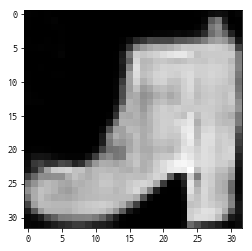

INFO:root:speed: 825.5640588767169 samples/s
INFO:root:discriminator loss = 0.106699, generator loss = 3.785429, binary training acc = 0.985092 at iter 500 epoch 13


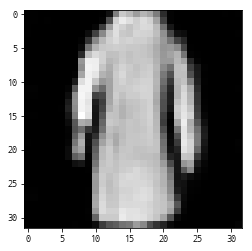

INFO:root:speed: 1068.8167165700452 samples/s
INFO:root:discriminator loss = 0.056687, generator loss = 4.926836, binary training acc = 0.984635 at iter 600 epoch 13


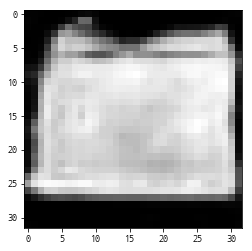

INFO:root:speed: 1075.0921397274976 samples/s
INFO:root:discriminator loss = 0.040266, generator loss = 5.450445, binary training acc = 0.985467 at iter 700 epoch 13


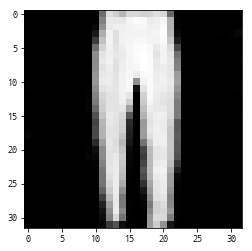

INFO:root:speed: 1060.1130111289265 samples/s
INFO:root:discriminator loss = 0.060511, generator loss = 4.600669, binary training acc = 0.983673 at iter 800 epoch 13


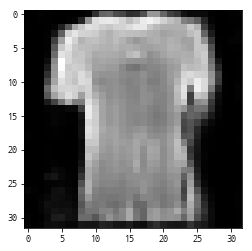

INFO:root:speed: 1038.2020900532955 samples/s
INFO:root:discriminator loss = 0.101142, generator loss = 4.539313, binary training acc = 0.983369 at iter 900 epoch 13


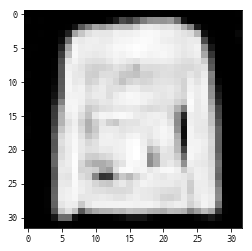

INFO:root:speed: 961.8170925716252 samples/s
INFO:root:discriminator loss = 0.008516, generator loss = 7.195786, binary training acc = 0.983563 at iter 1000 epoch 13


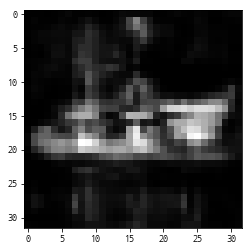

INFO:root:speed: 1276.416311625076 samples/s
INFO:root:discriminator loss = 0.008407, generator loss = 6.012535, binary training acc = 0.984999 at iter 1100 epoch 13


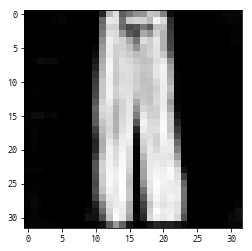

INFO:root:speed: 1052.704575758051 samples/s
INFO:root:discriminator loss = 0.004650, generator loss = 7.222530, binary training acc = 0.986248 at iter 1200 epoch 13


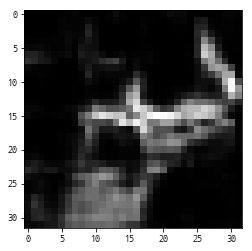

INFO:root:speed: 1360.4067301844718 samples/s
INFO:root:discriminator loss = 0.014907, generator loss = 5.696009, binary training acc = 0.984747 at iter 1300 epoch 13


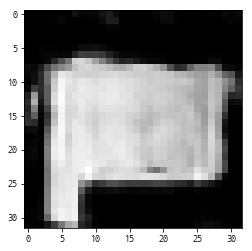

INFO:root:speed: 1083.2396694214876 samples/s
INFO:root:discriminator loss = 0.108970, generator loss = 6.047004, binary training acc = 0.985713 at iter 1400 epoch 13


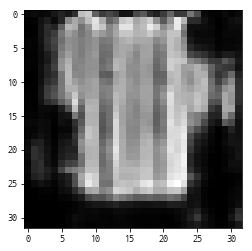

INFO:root:speed: 961.4932553924624 samples/s
INFO:root:discriminator loss = 0.001685, generator loss = 7.029430, binary training acc = 0.986624 at iter 1500 epoch 13


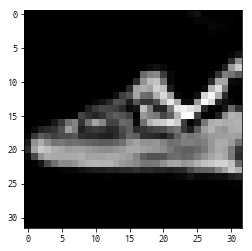

INFO:root:speed: 121.10780780509813 samples/s
INFO:root:discriminator loss = 0.004413, generator loss = 6.926138, binary training acc = 0.987459 at iter 1600 epoch 13


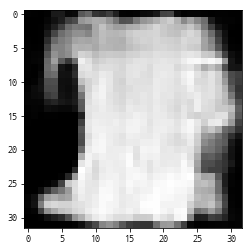

INFO:root:speed: 449.12154461342834 samples/s
INFO:root:discriminator loss = 0.009186, generator loss = 7.027641, binary training acc = 0.988169 at iter 1700 epoch 13


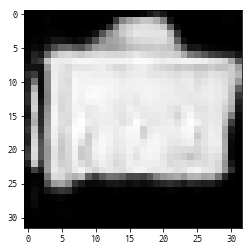

INFO:root:speed: 1128.6957633247557 samples/s
INFO:root:discriminator loss = 0.129003, generator loss = 8.744184, binary training acc = 0.988826 at iter 1800 epoch 13


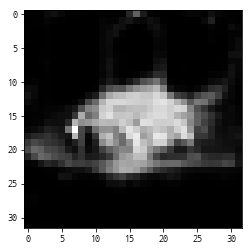

INFO:root:speed: 357.97790005147584 samples/s
INFO:root:discriminator loss = 0.191957, generator loss = 4.043971, binary training acc = 0.953125 at iter 0 epoch 14


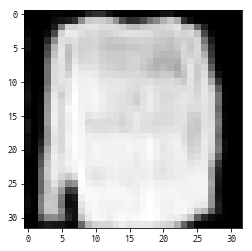

INFO:root:speed: 1134.7553496394119 samples/s
INFO:root:discriminator loss = 0.096866, generator loss = 5.391096, binary training acc = 0.991801 at iter 100 epoch 14


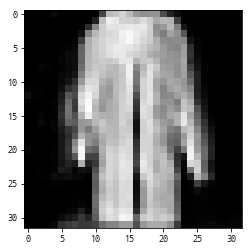

INFO:root:speed: 1140.880350889123 samples/s
INFO:root:discriminator loss = 0.059266, generator loss = 4.834786, binary training acc = 0.994092 at iter 200 epoch 14


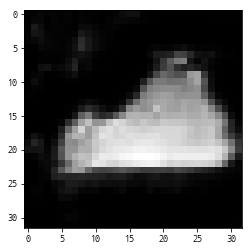

INFO:root:speed: 982.0426129712012 samples/s
INFO:root:discriminator loss = 0.128589, generator loss = 4.954083, binary training acc = 0.993511 at iter 300 epoch 14


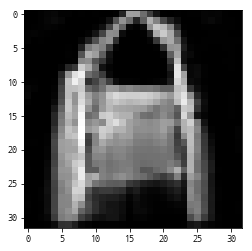

INFO:root:speed: 1386.6757033195236 samples/s
INFO:root:discriminator loss = 0.076093, generator loss = 4.859879, binary training acc = 0.988544 at iter 400 epoch 14


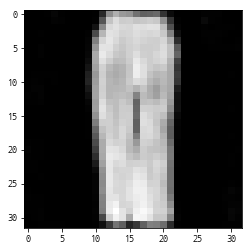

INFO:root:speed: 698.8213659059787 samples/s
INFO:root:discriminator loss = 0.071356, generator loss = 4.796396, binary training acc = 0.988617 at iter 500 epoch 14


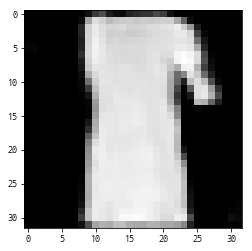

INFO:root:speed: 1234.7877862314508 samples/s
INFO:root:discriminator loss = 0.017269, generator loss = 5.892353, binary training acc = 0.989107 at iter 600 epoch 14


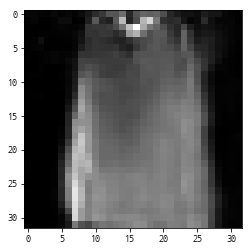

INFO:root:speed: 1032.324947121486 samples/s
INFO:root:discriminator loss = 0.005488, generator loss = 7.006007, binary training acc = 0.990393 at iter 700 epoch 14


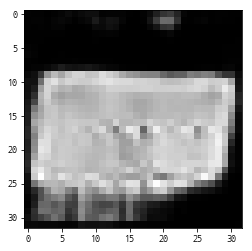

INFO:root:speed: 1031.5474087908203 samples/s
INFO:root:discriminator loss = 0.001209, generator loss = 7.872962, binary training acc = 0.991534 at iter 800 epoch 14


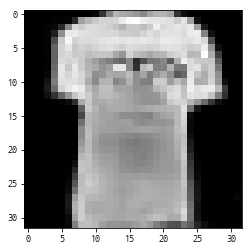

INFO:root:speed: 1095.6459784001763 samples/s
INFO:root:discriminator loss = 0.430049, generator loss = 4.867928, binary training acc = 0.987271 at iter 900 epoch 14


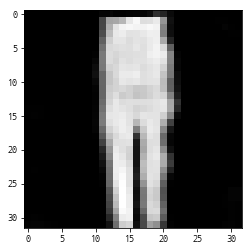

INFO:root:speed: 1233.9817593409825 samples/s
INFO:root:discriminator loss = 0.027775, generator loss = 5.621431, binary training acc = 0.985327 at iter 1000 epoch 14


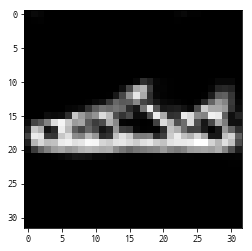

INFO:root:speed: 1118.826038028392 samples/s
INFO:root:discriminator loss = 0.018294, generator loss = 7.639153, binary training acc = 0.985652 at iter 1100 epoch 14


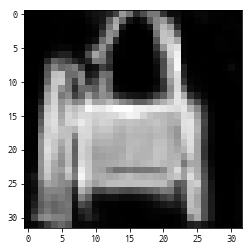

INFO:root:speed: 1138.9827562797013 samples/s
INFO:root:discriminator loss = 0.008206, generator loss = 6.575521, binary training acc = 0.986782 at iter 1200 epoch 14


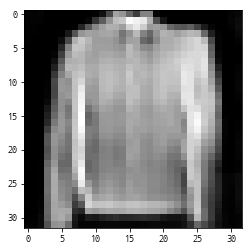

INFO:root:speed: 1033.5969196411381 samples/s
INFO:root:discriminator loss = 0.004520, generator loss = 6.734020, binary training acc = 0.987726 at iter 1300 epoch 14


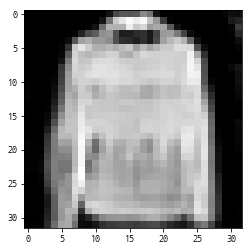

INFO:root:speed: 119.96589914721054 samples/s
INFO:root:discriminator loss = 0.000908, generator loss = 8.893158, binary training acc = 0.988580 at iter 1400 epoch 14


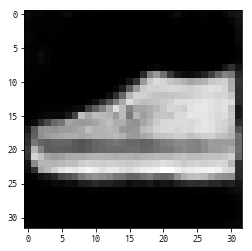

INFO:root:speed: 1293.9267514388455 samples/s
INFO:root:discriminator loss = 0.000494, generator loss = 9.014863, binary training acc = 0.989330 at iter 1500 epoch 14


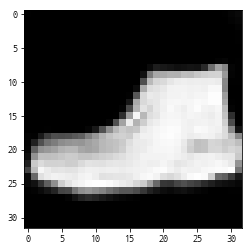

INFO:root:speed: 1183.8075111573673 samples/s
INFO:root:discriminator loss = 0.007044, generator loss = 7.398915, binary training acc = 0.989967 at iter 1600 epoch 14


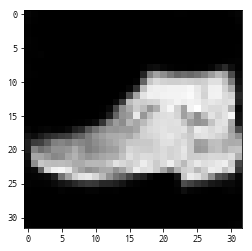

INFO:root:speed: 614.0242923870129 samples/s
INFO:root:discriminator loss = 0.001769, generator loss = 7.055061, binary training acc = 0.990548 at iter 1700 epoch 14


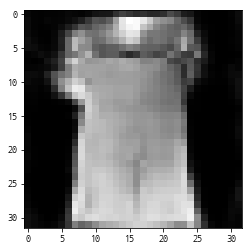

INFO:root:speed: 1216.6549851790749 samples/s
INFO:root:discriminator loss = 0.018895, generator loss = 6.321345, binary training acc = 0.990977 at iter 1800 epoch 14


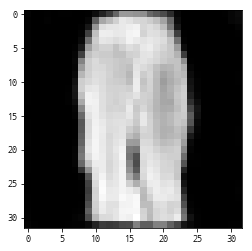

INFO:root:speed: 341.29687889375424 samples/s
INFO:root:discriminator loss = 0.002764, generator loss = 8.012159, binary training acc = 1.000000 at iter 0 epoch 15


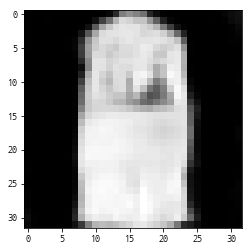

INFO:root:speed: 960.1313961556896 samples/s
INFO:root:discriminator loss = 0.000668, generator loss = 8.323351, binary training acc = 0.999845 at iter 100 epoch 15


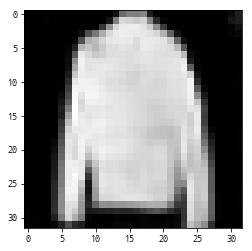

INFO:root:speed: 1149.1538995008434 samples/s
INFO:root:discriminator loss = 0.001003, generator loss = 8.227377, binary training acc = 0.999922 at iter 200 epoch 15


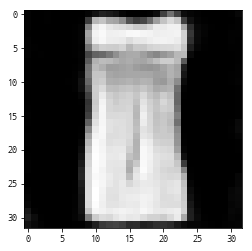

INFO:root:speed: 633.3444759554358 samples/s
INFO:root:discriminator loss = 0.008437, generator loss = 8.308140, binary training acc = 0.999948 at iter 300 epoch 15


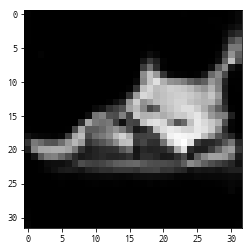

INFO:root:speed: 935.439033739659 samples/s
INFO:root:discriminator loss = 0.013442, generator loss = 8.749737, binary training acc = 0.999922 at iter 400 epoch 15


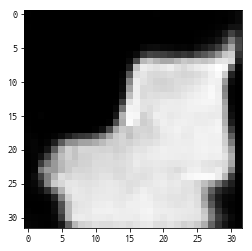

INFO:root:speed: 1018.8309131071757 samples/s
INFO:root:discriminator loss = 0.000958, generator loss = 10.599667, binary training acc = 0.999906 at iter 500 epoch 15


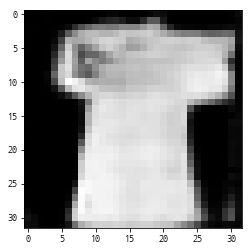

INFO:root:speed: 886.704023994662 samples/s
INFO:root:discriminator loss = 0.151639, generator loss = 5.435463, binary training acc = 0.991473 at iter 600 epoch 15


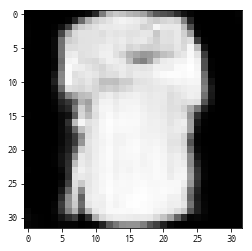

INFO:root:speed: 1321.573942240471 samples/s
INFO:root:discriminator loss = 0.126593, generator loss = 5.628859, binary training acc = 0.990549 at iter 700 epoch 15


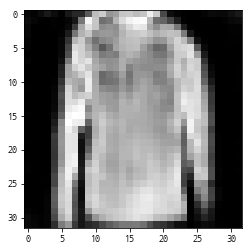

INFO:root:speed: 223.4775777697486 samples/s
INFO:root:discriminator loss = 0.060601, generator loss = 5.945588, binary training acc = 0.989466 at iter 800 epoch 15


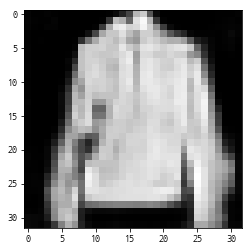

INFO:root:speed: 1286.4976612222988 samples/s
INFO:root:discriminator loss = 0.019264, generator loss = 6.076075, binary training acc = 0.989682 at iter 900 epoch 15


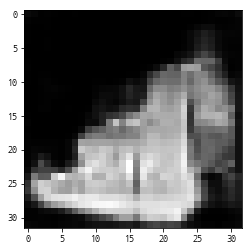

INFO:root:speed: 1014.1580124523967 samples/s
INFO:root:discriminator loss = 1.233079, generator loss = 0.357775, binary training acc = 0.990119 at iter 1000 epoch 15


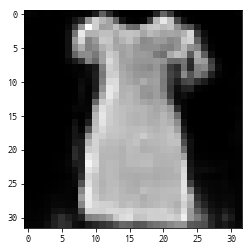

INFO:root:speed: 1159.2379405947436 samples/s
INFO:root:discriminator loss = 0.003439, generator loss = 8.653782, binary training acc = 0.988973 at iter 1100 epoch 15


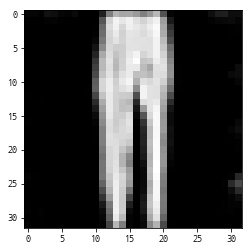

INFO:root:speed: 1106.4301977627013 samples/s
INFO:root:discriminator loss = 0.014524, generator loss = 6.357764, binary training acc = 0.987758 at iter 1200 epoch 15


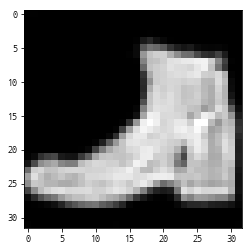

INFO:root:speed: 1221.3714316914034 samples/s
INFO:root:discriminator loss = 0.078254, generator loss = 5.352335, binary training acc = 0.988470 at iter 1300 epoch 15


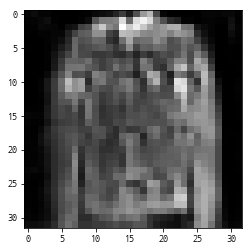

INFO:root:speed: 1053.6549461074085 samples/s
INFO:root:discriminator loss = 0.089383, generator loss = 5.130377, binary training acc = 0.986550 at iter 1400 epoch 15


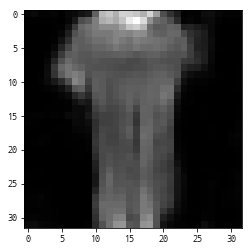

INFO:root:speed: 1360.0483148572239 samples/s
INFO:root:discriminator loss = 0.256776, generator loss = 3.612189, binary training acc = 0.984479 at iter 1500 epoch 15


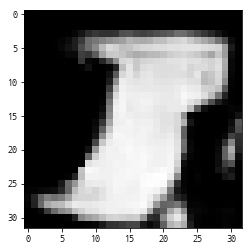

INFO:root:speed: 1025.478694712071 samples/s
INFO:root:discriminator loss = 0.014960, generator loss = 6.570332, binary training acc = 0.984326 at iter 1600 epoch 15


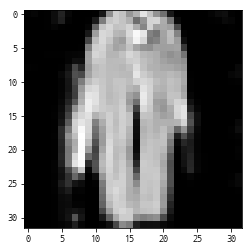

INFO:root:speed: 1047.970142261505 samples/s
INFO:root:discriminator loss = 0.003034, generator loss = 7.709455, binary training acc = 0.985202 at iter 1700 epoch 15


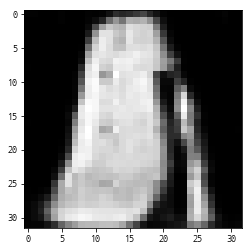

INFO:root:speed: 171.08064583973314 samples/s
INFO:root:discriminator loss = 0.348734, generator loss = 3.029441, binary training acc = 0.984340 at iter 1800 epoch 15


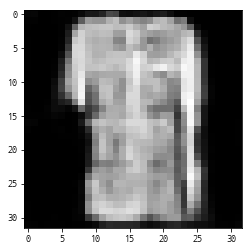

INFO:root:speed: 414.33025353538784 samples/s
INFO:root:discriminator loss = 0.152876, generator loss = 5.196695, binary training acc = 0.953125 at iter 0 epoch 16


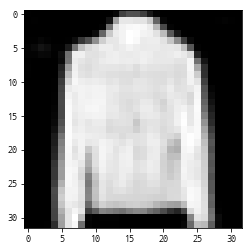

INFO:root:speed: 1072.9435539958272 samples/s
INFO:root:discriminator loss = 0.010028, generator loss = 6.800317, binary training acc = 0.990408 at iter 100 epoch 16


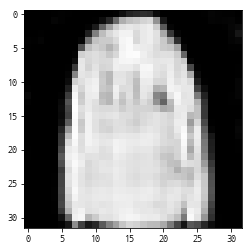

INFO:root:speed: 999.0675211957453 samples/s
INFO:root:discriminator loss = 0.020501, generator loss = 5.620999, binary training acc = 0.981732 at iter 200 epoch 16


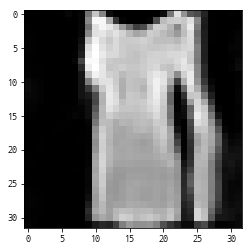

INFO:root:speed: 728.9489640190088 samples/s
INFO:root:discriminator loss = 0.252207, generator loss = 2.683817, binary training acc = 0.979755 at iter 300 epoch 16


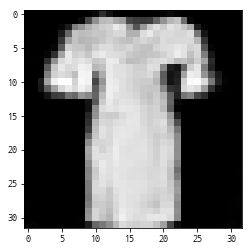

INFO:root:speed: 1029.150779045516 samples/s
INFO:root:discriminator loss = 0.038918, generator loss = 6.339241, binary training acc = 0.980634 at iter 400 epoch 16


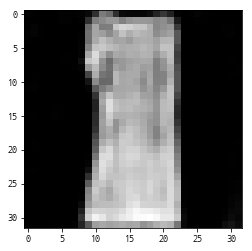

INFO:root:speed: 1326.30145162406 samples/s
INFO:root:discriminator loss = 0.021448, generator loss = 5.546403, binary training acc = 0.984313 at iter 500 epoch 16


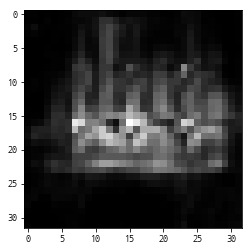

INFO:root:speed: 1202.9911983508111 samples/s
INFO:root:discriminator loss = 0.027970, generator loss = 5.271588, binary training acc = 0.986637 at iter 600 epoch 16


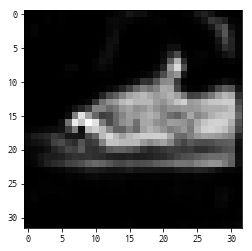

INFO:root:speed: 324.86283014483774 samples/s
INFO:root:discriminator loss = 0.005052, generator loss = 6.928808, binary training acc = 0.988387 at iter 700 epoch 16


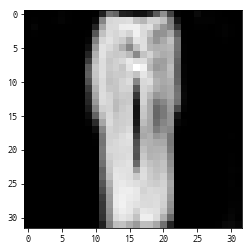

INFO:root:speed: 983.9865104617235 samples/s
INFO:root:discriminator loss = 0.046408, generator loss = 5.334226, binary training acc = 0.987106 at iter 800 epoch 16


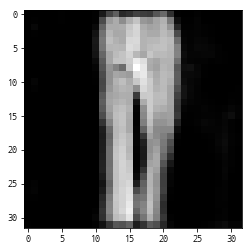

INFO:root:speed: 579.9295189208341 samples/s
INFO:root:discriminator loss = 0.011763, generator loss = 6.003428, binary training acc = 0.987583 at iter 900 epoch 16


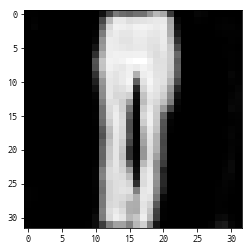

INFO:root:speed: 1138.6059264160708 samples/s
INFO:root:discriminator loss = 0.007348, generator loss = 7.145668, binary training acc = 0.988683 at iter 1000 epoch 16


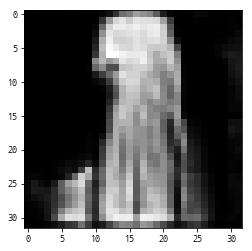

INFO:root:speed: 1413.9344535159337 samples/s
INFO:root:discriminator loss = 0.017751, generator loss = 7.128389, binary training acc = 0.989697 at iter 1100 epoch 16


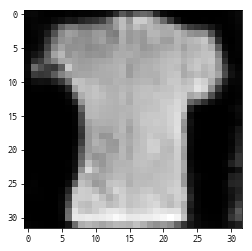

INFO:root:speed: 887.4075386619239 samples/s
INFO:root:discriminator loss = 0.014993, generator loss = 5.914405, binary training acc = 0.990542 at iter 1200 epoch 16


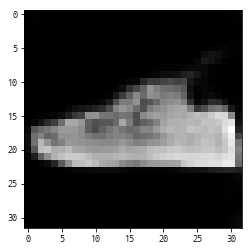

INFO:root:speed: 1125.874307955575 samples/s
INFO:root:discriminator loss = 0.138962, generator loss = 4.113052, binary training acc = 0.989275 at iter 1300 epoch 16


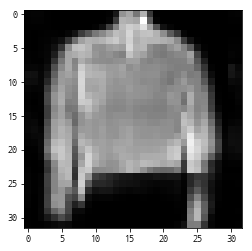

INFO:root:speed: 1196.5670372384527 samples/s
INFO:root:discriminator loss = 0.042591, generator loss = 5.085727, binary training acc = 0.989249 at iter 1400 epoch 16


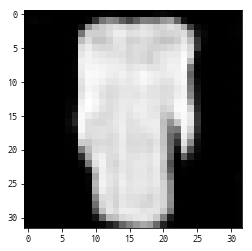

INFO:root:speed: 794.3851608091952 samples/s
INFO:root:discriminator loss = 0.544281, generator loss = 7.551734, binary training acc = 0.989663 at iter 1500 epoch 16


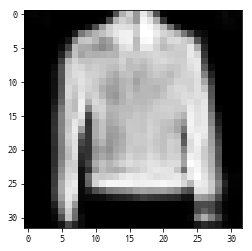

INFO:root:speed: 1063.321275500099 samples/s
INFO:root:discriminator loss = 0.047984, generator loss = 6.146075, binary training acc = 0.986629 at iter 1600 epoch 16


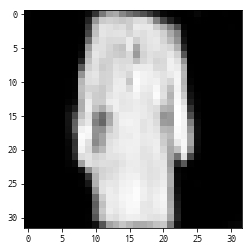

INFO:root:speed: 935.9543660478934 samples/s
INFO:root:discriminator loss = 0.003859, generator loss = 7.038612, binary training acc = 0.987397 at iter 1700 epoch 16


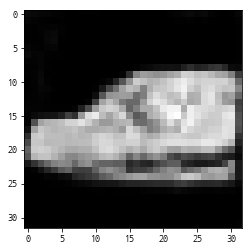

INFO:root:speed: 915.2935303705017 samples/s
INFO:root:discriminator loss = 0.051938, generator loss = 8.378513, binary training acc = 0.988054 at iter 1800 epoch 16


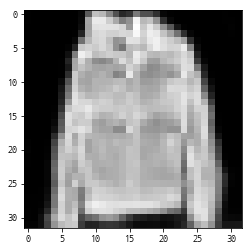

INFO:root:speed: 305.19149942471495 samples/s
INFO:root:discriminator loss = 0.026248, generator loss = 6.481313, binary training acc = 1.000000 at iter 0 epoch 17


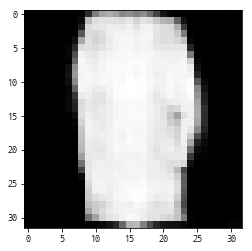

INFO:root:speed: 1349.735800482703 samples/s
INFO:root:discriminator loss = 0.004833, generator loss = 7.164211, binary training acc = 0.997215 at iter 100 epoch 17


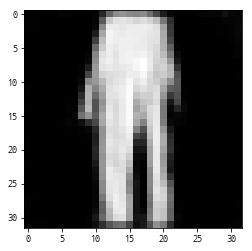

INFO:root:speed: 775.780174556384 samples/s
INFO:root:discriminator loss = 0.016985, generator loss = 6.323100, binary training acc = 0.998290 at iter 200 epoch 17


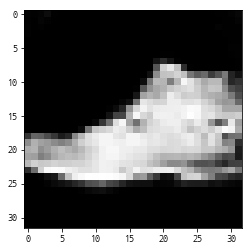

INFO:root:speed: 1313.0922858680233 samples/s
INFO:root:discriminator loss = 0.003947, generator loss = 7.411495, binary training acc = 0.998754 at iter 300 epoch 17


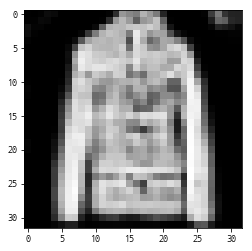

INFO:root:speed: 1127.4916037331675 samples/s
INFO:root:discriminator loss = 0.001052, generator loss = 8.509275, binary training acc = 0.999065 at iter 400 epoch 17


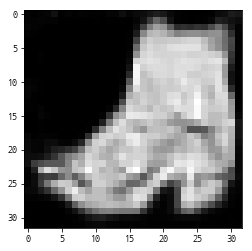

INFO:root:speed: 1210.1826575419045 samples/s
INFO:root:discriminator loss = 0.000698, generator loss = 8.199281, binary training acc = 0.999096 at iter 500 epoch 17


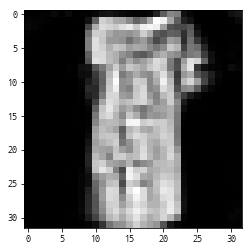

INFO:root:speed: 1183.9745946613505 samples/s
INFO:root:discriminator loss = 0.083131, generator loss = 5.981053, binary training acc = 0.995190 at iter 600 epoch 17


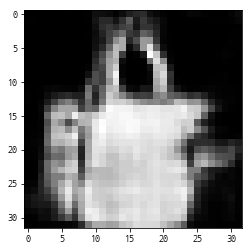

INFO:root:speed: 352.93241789883064 samples/s
INFO:root:discriminator loss = 0.008763, generator loss = 7.012475, binary training acc = 0.994405 at iter 700 epoch 17


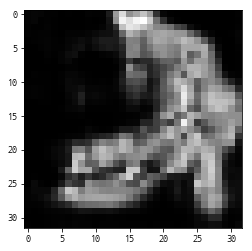

INFO:root:speed: 539.3822758764809 samples/s
INFO:root:discriminator loss = 0.064997, generator loss = 5.273983, binary training acc = 0.994850 at iter 800 epoch 17


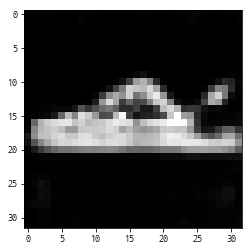

INFO:root:speed: 1382.4052734576167 samples/s
INFO:root:discriminator loss = 0.005712, generator loss = 7.581294, binary training acc = 0.995387 at iter 900 epoch 17


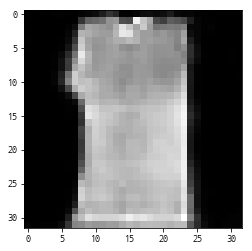

INFO:root:speed: 967.0770893527492 samples/s
INFO:root:discriminator loss = 0.008910, generator loss = 9.614762, binary training acc = 0.995754 at iter 1000 epoch 17


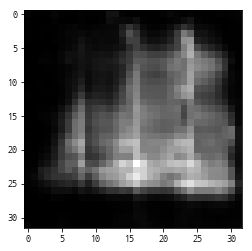

INFO:root:speed: 333.7039427557023 samples/s
INFO:root:discriminator loss = 0.311749, generator loss = 5.535820, binary training acc = 0.992109 at iter 1100 epoch 17


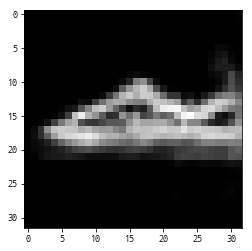

INFO:root:speed: 792.7242487242487 samples/s
INFO:root:discriminator loss = 0.056919, generator loss = 5.365361, binary training acc = 0.991674 at iter 1200 epoch 17


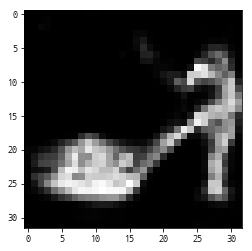

INFO:root:speed: 1069.29356277884 samples/s
INFO:root:discriminator loss = 0.017589, generator loss = 5.927398, binary training acc = 0.991845 at iter 1300 epoch 17


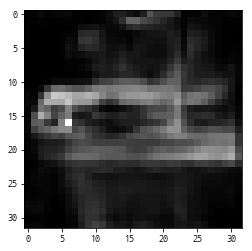

INFO:root:speed: 165.07300994611853 samples/s
INFO:root:discriminator loss = 0.004131, generator loss = 7.176854, binary training acc = 0.992305 at iter 1400 epoch 17


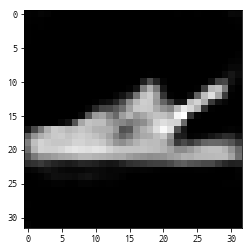

INFO:root:speed: 1392.444527440606 samples/s
INFO:root:discriminator loss = 0.000622, generator loss = 9.113686, binary training acc = 0.992796 at iter 1500 epoch 17


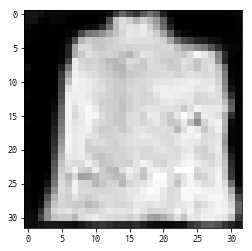

INFO:root:speed: 1193.2798236099504 samples/s
INFO:root:discriminator loss = 0.006028, generator loss = 8.188401, binary training acc = 0.993237 at iter 1600 epoch 17


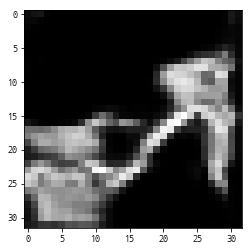

INFO:root:speed: 1142.006398475257 samples/s
INFO:root:discriminator loss = 0.116341, generator loss = 5.271406, binary training acc = 0.990612 at iter 1700 epoch 17


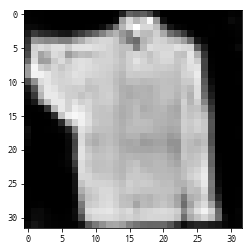

INFO:root:speed: 1160.0896141612502 samples/s
INFO:root:discriminator loss = 0.036174, generator loss = 6.160126, binary training acc = 0.990144 at iter 1800 epoch 17


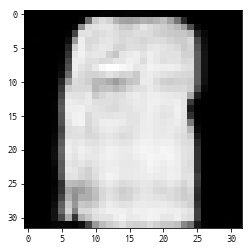

INFO:root:speed: 323.0791198580758 samples/s
INFO:root:discriminator loss = 0.045366, generator loss = 4.822412, binary training acc = 1.000000 at iter 0 epoch 18


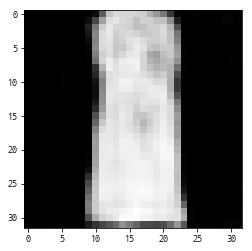

INFO:root:speed: 197.97351458349928 samples/s
INFO:root:discriminator loss = 0.060821, generator loss = 6.346903, binary training acc = 0.997370 at iter 100 epoch 18


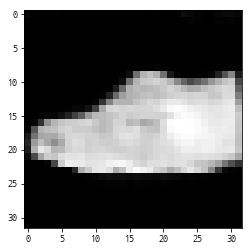

INFO:root:speed: 1258.9245964375827 samples/s
INFO:root:discriminator loss = 0.166636, generator loss = 7.530915, binary training acc = 0.989739 at iter 200 epoch 18


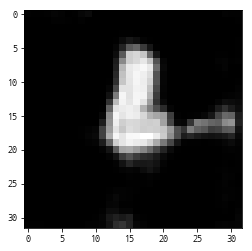

INFO:root:speed: 1055.785032172805 samples/s
INFO:root:discriminator loss = 0.026050, generator loss = 6.537492, binary training acc = 0.992681 at iter 300 epoch 18


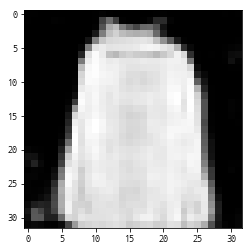

INFO:root:speed: 1232.3615429111844 samples/s
INFO:root:discriminator loss = 0.002409, generator loss = 7.003635, binary training acc = 0.994233 at iter 400 epoch 18


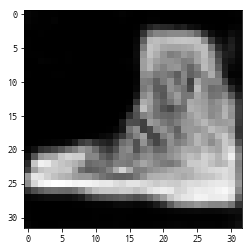

INFO:root:speed: 1173.806478695865 samples/s
INFO:root:discriminator loss = 0.006155, generator loss = 7.432328, binary training acc = 0.995384 at iter 500 epoch 18


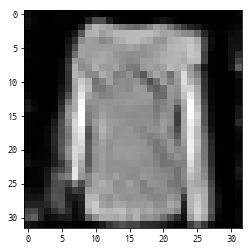

INFO:root:speed: 1364.5421254358944 samples/s
INFO:root:discriminator loss = 0.127546, generator loss = 4.921498, binary training acc = 0.986923 at iter 600 epoch 18


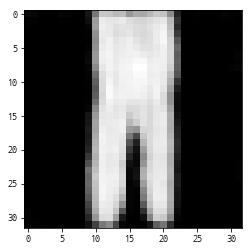

INFO:root:speed: 718.910571195955 samples/s
INFO:root:discriminator loss = 0.852240, generator loss = 0.859382, binary training acc = 0.985512 at iter 700 epoch 18


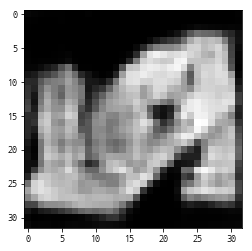

INFO:root:speed: 979.5055536905405 samples/s
INFO:root:discriminator loss = 0.032749, generator loss = 5.875288, binary training acc = 0.984570 at iter 800 epoch 18


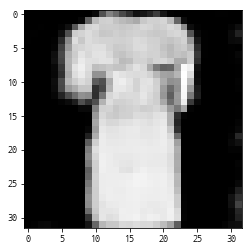

INFO:root:speed: 1051.236943513268 samples/s
INFO:root:discriminator loss = 0.004852, generator loss = 7.886668, binary training acc = 0.986231 at iter 900 epoch 18


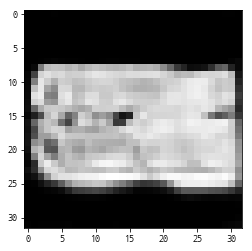

INFO:root:speed: 379.07544921003426 samples/s
INFO:root:discriminator loss = 0.001166, generator loss = 8.973001, binary training acc = 0.987559 at iter 1000 epoch 18


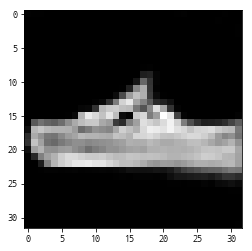

INFO:root:speed: 1007.5573939089114 samples/s
INFO:root:discriminator loss = 0.005889, generator loss = 6.013857, binary training acc = 0.986546 at iter 1100 epoch 18


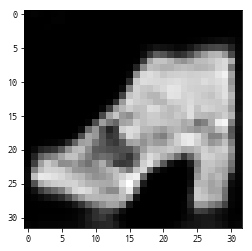

INFO:root:speed: 973.3610460436141 samples/s
INFO:root:discriminator loss = 0.292651, generator loss = 4.085845, binary training acc = 0.986326 at iter 1200 epoch 18


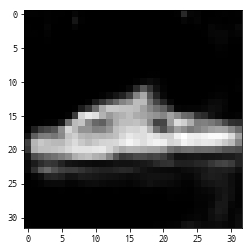

INFO:root:speed: 1048.2975459643533 samples/s
INFO:root:discriminator loss = 0.007093, generator loss = 7.253243, binary training acc = 0.986993 at iter 1300 epoch 18


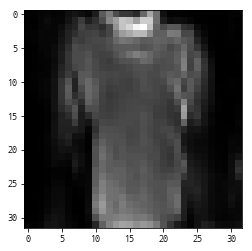

INFO:root:speed: 1379.081500965846 samples/s
INFO:root:discriminator loss = 0.001647, generator loss = 7.601813, binary training acc = 0.987799 at iter 1400 epoch 18


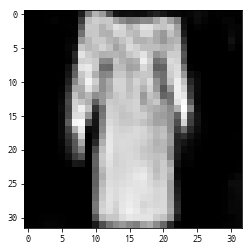

INFO:root:speed: 1288.7953755449291 samples/s
INFO:root:discriminator loss = 0.006122, generator loss = 7.262665, binary training acc = 0.988581 at iter 1500 epoch 18


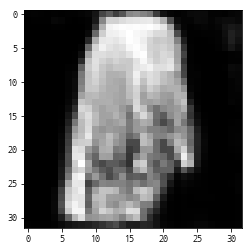

INFO:root:speed: 1293.1787376311556 samples/s
INFO:root:discriminator loss = 0.156411, generator loss = 5.359169, binary training acc = 0.986024 at iter 1600 epoch 18


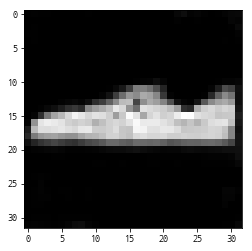

INFO:root:speed: 1083.8344907781259 samples/s
INFO:root:discriminator loss = 0.020066, generator loss = 6.106650, binary training acc = 0.986231 at iter 1700 epoch 18


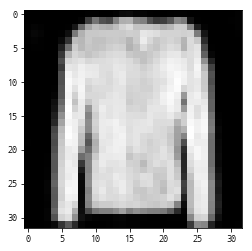

INFO:root:speed: 412.6437006361006 samples/s
INFO:root:discriminator loss = 0.053584, generator loss = 5.723680, binary training acc = 0.986908 at iter 1800 epoch 18


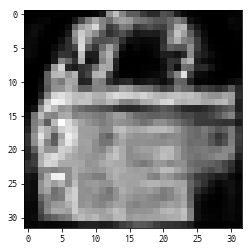

INFO:root:speed: 313.0128710123533 samples/s
INFO:root:discriminator loss = 0.007624, generator loss = 6.073184, binary training acc = 1.000000 at iter 0 epoch 19


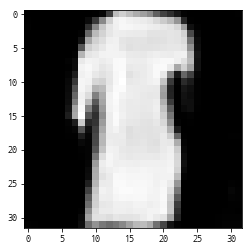

INFO:root:speed: 1192.5376550449587 samples/s
INFO:root:discriminator loss = 0.012020, generator loss = 7.369149, binary training acc = 0.999536 at iter 100 epoch 19


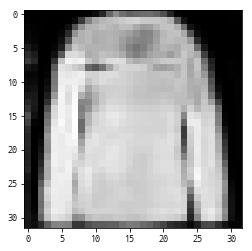

INFO:root:speed: 289.6381253263933 samples/s
INFO:root:discriminator loss = 0.001475, generator loss = 7.444706, binary training acc = 0.999689 at iter 200 epoch 19


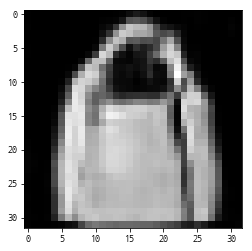

INFO:root:speed: 769.491170939779 samples/s
INFO:root:discriminator loss = 0.006748, generator loss = 6.385062, binary training acc = 0.999740 at iter 300 epoch 19


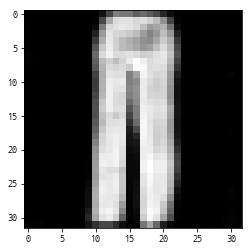

INFO:root:speed: 709.2198449645173 samples/s
INFO:root:discriminator loss = 0.014031, generator loss = 6.633593, binary training acc = 0.999688 at iter 400 epoch 19


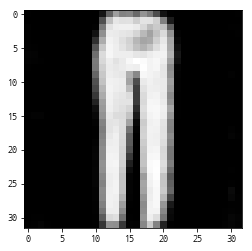

INFO:root:speed: 1260.4260466164567 samples/s
INFO:root:discriminator loss = 0.066464, generator loss = 5.932736, binary training acc = 0.994636 at iter 500 epoch 19


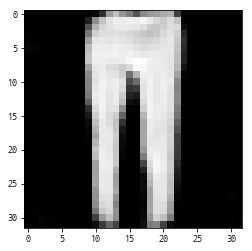

INFO:root:speed: 1221.2047385947992 samples/s
INFO:root:discriminator loss = 0.053367, generator loss = 5.659477, binary training acc = 0.995086 at iter 600 epoch 19


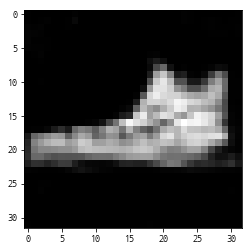

INFO:root:speed: 995.9538448980803 samples/s
INFO:root:discriminator loss = 0.071537, generator loss = 9.039529, binary training acc = 0.994093 at iter 700 epoch 19


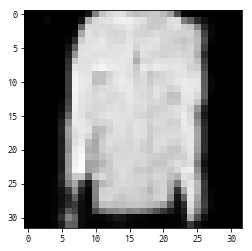

INFO:root:speed: 789.697212890016 samples/s
INFO:root:discriminator loss = 0.031914, generator loss = 6.402755, binary training acc = 0.994324 at iter 800 epoch 19


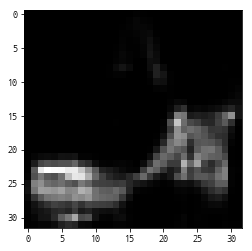

INFO:root:speed: 1083.2571548481865 samples/s
INFO:root:discriminator loss = 0.031540, generator loss = 5.824679, binary training acc = 0.992023 at iter 900 epoch 19


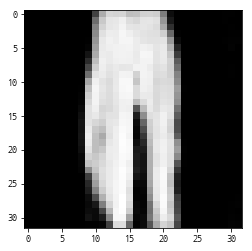

INFO:root:speed: 1037.3194630146304 samples/s
INFO:root:discriminator loss = 0.029485, generator loss = 6.654160, binary training acc = 0.990978 at iter 1000 epoch 19


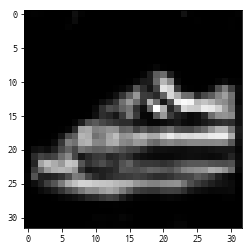

INFO:root:speed: 192.38520119658682 samples/s
INFO:root:discriminator loss = 0.170219, generator loss = 3.789762, binary training acc = 0.991272 at iter 1100 epoch 19


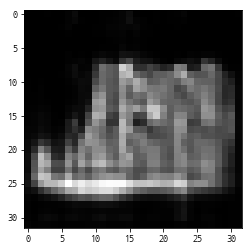

INFO:root:speed: 1161.635838050233 samples/s
INFO:root:discriminator loss = 0.136503, generator loss = 4.828013, binary training acc = 0.989072 at iter 1200 epoch 19


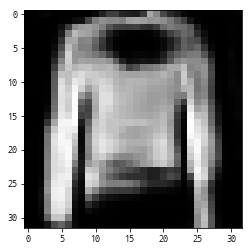

INFO:root:speed: 311.38764497217136 samples/s
INFO:root:discriminator loss = 0.010150, generator loss = 6.577517, binary training acc = 0.988951 at iter 1300 epoch 19


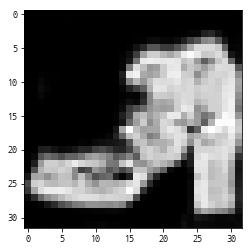

INFO:root:speed: 1325.2668746790948 samples/s
INFO:root:discriminator loss = 0.003243, generator loss = 7.921594, binary training acc = 0.989673 at iter 1400 epoch 19


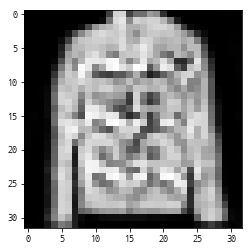

INFO:root:speed: 1327.5214432663397 samples/s
INFO:root:discriminator loss = 0.255456, generator loss = 0.708952, binary training acc = 0.990225 at iter 1500 epoch 19


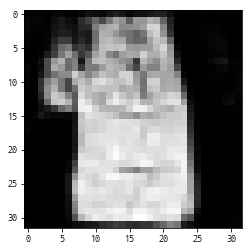

INFO:root:speed: 1253.9728310630267 samples/s
INFO:root:discriminator loss = 0.003210, generator loss = 7.080771, binary training acc = 0.989967 at iter 1600 epoch 19


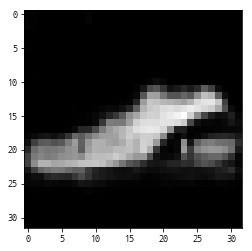

INFO:root:speed: 644.3822189361896 samples/s
INFO:root:discriminator loss = 0.001132, generator loss = 9.922733, binary training acc = 0.990529 at iter 1700 epoch 19


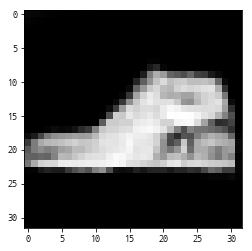

INFO:root:speed: 1064.274042121289 samples/s
INFO:root:discriminator loss = 0.026585, generator loss = 7.697929, binary training acc = 0.991038 at iter 1800 epoch 19


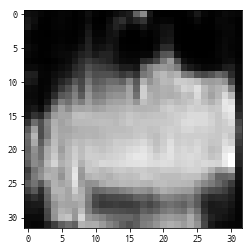

In [22]:
from datetime import datetime
import time
import logging

real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()
metric = mx.metric.CustomMetric(facc)

stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
logging.basicConfig(level=logging.DEBUG)

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    iter = 0
    for (data, label) in train_data:
        # 원래 데이터 형태는 1 X 28 X 28임 -> DCGAN 네트워크 활용을 위해서 이미지 데이터의 크기를 조절
        X = np.zeros((batch_size, 28, 28))
        for idx in range(data.shape[0]):
            X[idx] = data.asnumpy()[idx,0,:,:]
        X = np.asarray([cv2.resize(x, (32,32)) for x in X])
        X = X.reshape((batch_size,1,32,32))
        data = nd.array(X,ctx=ctx)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)
    
        #Gradient를 산출 및 이를 Back prop.에 적용
        with autograd.record():
            # train with real image
            output = netD(data).reshape((-1, 1))
            errD_real = loss(output, real_label)
            metric.update([real_label,], [output,])

            # train with fake image
            fake = netG(latent_z)
            output = netD(fake.detach()).reshape((-1, 1))
            errD_fake = loss(output, fake_label)
            errD = errD_real + errD_fake
            errD.backward()
            metric.update([fake_label,], [output,])

        trainerD.step(data.shape[0])

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        with autograd.record():
            fake = netG(latent_z)
            output = netD(fake).reshape((-1, 1))
            errG = loss(output, real_label)
            errG.backward()

        trainerG.step(data.shape[0])

        # Print log infomation every ten batches
        if iter % 100 == 0:
            name, acc = metric.get()
            logging.info('speed: {} samples/s'.format(batch_size / (time.time() - btic)))
            logging.info('discriminator loss = %f, generator loss = %f, binary training acc = %f at iter %d epoch %d'
                     %(nd.mean(errD).asscalar(),
                       nd.mean(errG).asscalar(), acc, iter, epoch))
            fake_img = fake[0][0].asnumpy()
            imgplot = plt.imshow((fake_img +1)*127.5,cmap='gray')
            plt.show()
        iter = iter + 1
        btic = time.time()

    name, acc = metric.get()
    metric.reset()
    # logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
    # logging.info('time: %f' % (time.time() - tic))

    # Visualize one generated image for each epoch


## 결과 시각화 작업

In [33]:
latent_z = mx.nd.random_normal(0, 1, shape=(16, latent_z_size, 1, 1), ctx=ctx)

In [34]:
fake = netG(latent_z)

In [36]:
fake.shape

(16, 1, 32, 32)

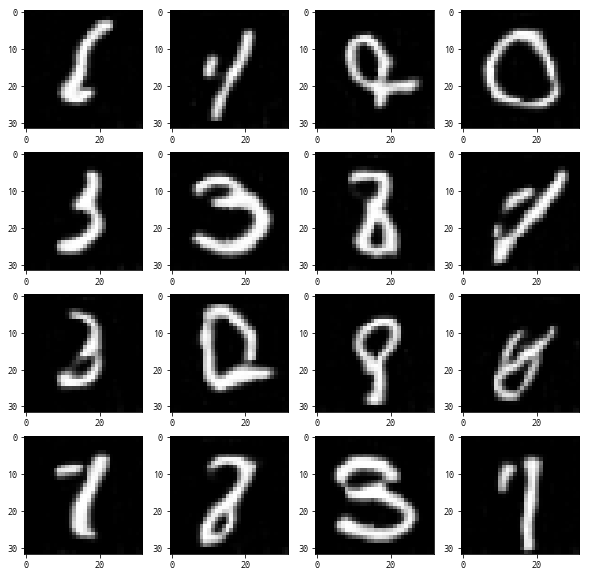

In [39]:
fig=plt.figure(figsize=(10, 10))
columns = 4
rows = 4
for i in range(fake.shape[0]):
    fake_img = fake[i][0].asnumpy()
    fig.add_subplot(rows, columns, i+1)
    plt.imshow((fake_img +1)*127.5,cmap='gray')
plt.show()